# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [2]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

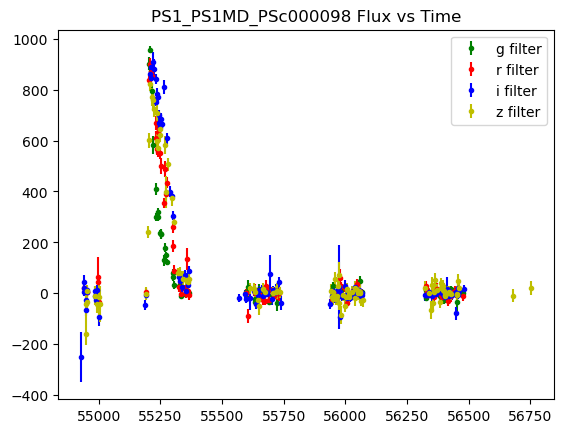

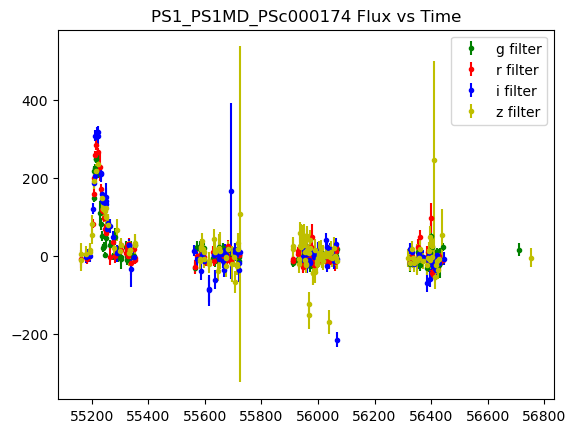

In [80]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
from scipy import optimize
import pandas as pd
from astropy.table import Table
import scipy.stats
import scipy.optimize as so

#File_98 = pd.read_csv('PS1_PS1MD_PSc000098.snana.dat', sep=' ', usecols = ['MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
#File_98 = pd.read_csv('PS1_PS1MD_PSc000098.snana.dat')
#data_top = File_98.head()

File_98 = Table.read('PS1_PS1MD_PSc000098.snana.dat', comment='#', format='ascii.csv', names=['VARLIST:','MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'], data_start = 18, delimiter=' ')
#print(File_98['FLT'])
#print(data_top)

g_MJD_98 = np.array(File_98['MJD'][np.where(File_98['FLT'] == 'g')])
g_flux_98 = np.array(File_98['FLUXCAL'][np.where(File_98['FLT'] == 'g')])
g_fluxerr_98 = np.array(File_98['FLUXCALERR'][np.where(File_98['FLT'] == 'g')])
#print(g_98)

r_MJD_98 = np.array(File_98['MJD'][np.where(File_98['FLT'] == 'r')])
r_flux_98 = np.array(File_98['FLUXCAL'][np.where(File_98['FLT'] == 'r')])
r_fluxerr_98 = np.array(File_98['FLUXCALERR'][np.where(File_98['FLT'] == 'r')])

i_MJD_98 = np.array(File_98['MJD'][np.where(File_98['FLT'] == 'i')])
i_flux_98 = np.array(File_98['FLUXCAL'][np.where(File_98['FLT'] == 'i')])
i_fluxerr_98 = np.array(File_98['FLUXCALERR'][np.where(File_98['FLT'] == 'i')])

z_MJD_98 = np.array(File_98['MJD'][np.where(File_98['FLT'] == 'z')])
z_flux_98 = np.array(File_98['FLUXCAL'][np.where(File_98['FLT'] == 'z')])
z_fluxerr_98 = np.array(File_98['FLUXCALERR'][np.where(File_98['FLT'] == 'z')])

plt.errorbar(g_MJD_98, g_flux_98, g_fluxerr_98, fmt='g.', label='g filter')
plt.errorbar(r_MJD_98, r_flux_98, r_fluxerr_98, fmt='r.', label='r filter')
plt.errorbar(i_MJD_98, i_flux_98, i_fluxerr_98, fmt='b.', label='i filter')
plt.errorbar(z_MJD_98, z_flux_98, z_fluxerr_98, fmt='y.', label='z filter')
plt.title('PS1_PS1MD_PSc000098 Flux vs Time')
plt.legend()
plt.show()

File_98_MJD = [g_MJD_98, r_MJD_98, i_MJD_98, z_MJD_98]
File_98_flux = [g_flux_98, r_flux_98, i_flux_98, z_flux_98]
File_98_fluxerr = [g_fluxerr_98, r_fluxerr_98, i_fluxerr_98, z_fluxerr_98]

File_174 = Table.read('PS1_PS1MD_PSc000174.snana.dat', comment='#', format='ascii.csv', names=['VARLIST:','MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'], data_start = 18, delimiter=' ')
#print(File_98['FLT'])
#print(data_top)

g_MJD_174 = np.array(File_174['MJD'][np.where(File_174['FLT'] == 'g')])
g_flux_174 = np.array(File_174['FLUXCAL'][np.where(File_174['FLT'] == 'g')])
g_fluxerr_174 = np.array(File_174['FLUXCALERR'][np.where(File_174['FLT'] == 'g')])
#print(g_98)

r_MJD_174 = np.array(File_174['MJD'][np.where(File_174['FLT'] == 'r')])
r_flux_174 = np.array(File_174['FLUXCAL'][np.where(File_174['FLT'] == 'r')])
r_fluxerr_174 = np.array(File_174['FLUXCALERR'][np.where(File_174['FLT'] == 'r')])

i_MJD_174 = np.array(File_174['MJD'][np.where(File_174['FLT'] == 'i')])
i_flux_174 = np.array(File_174['FLUXCAL'][np.where(File_174['FLT'] == 'i')])
i_fluxerr_174 = np.array(File_174['FLUXCALERR'][np.where(File_174['FLT'] == 'i')])

z_MJD_174 = np.array(File_174['MJD'][np.where(File_174['FLT'] == 'z')])
z_flux_174 = np.array(File_174['FLUXCAL'][np.where(File_174['FLT'] == 'z')])
z_fluxerr_174 = np.array(File_174['FLUXCALERR'][np.where(File_174['FLT'] == 'z')])

plt.errorbar(g_MJD_174, g_flux_174, g_fluxerr_174, fmt='g.', label='g filter')
plt.errorbar(r_MJD_174, r_flux_174, r_fluxerr_174, fmt='r.', label='r filter')
plt.errorbar(i_MJD_174, i_flux_174, i_fluxerr_174, fmt='b.', label='i filter')
plt.errorbar(z_MJD_174, z_flux_174, z_fluxerr_174, fmt='y.', label='z filter')
plt.title('PS1_PS1MD_PSc000174 Flux vs Time')
plt.legend()
plt.show()

File_174_MJD = [g_MJD_174, r_MJD_174, i_MJD_174, z_MJD_174]
File_174_flux = [g_flux_174, r_flux_174, i_flux_174, z_flux_174]
File_174_fluxerr = [g_fluxerr_174, r_fluxerr_174, i_fluxerr_174, z_fluxerr_174]



In [62]:

ndim = 6
# have theta be array of [Trise, Tfall, t0, A, Beta, g: (t1-t0)]

def model(theta, t):
    Trise = theta[0]
    Tfall = theta[1]
    t0 = theta[2]
    A = theta[3]
    Beta = theta[4]
    g = theta[5]
    t1 = g + t0
    
    F_mod = np.zeros(len(t))
    
    mask = np.where(t<t1)
    mask2 = np.where(t>=t1)
    
    F_mod[mask] = np.nan_to_num((A+Beta*(t[mask]-t0))/(1+np.exp(-1*(t[mask]-t0)/Trise)))
    F_mod[mask2] = np.nan_to_num(((A+Beta*(t1-t0))/(1+np.exp(-1*(t[mask2]-t0)/Trise)))*np.exp(-1*(t[mask2]-t1)/Tfall))
    
    return F_mod
    

def log_prior(theta, t, F):
    #Trise
    if theta[0] > 0.01 and theta[0] < 50:
        pr_tr = np.log(1/(50-0.01))
    else:
        pr_tr = -1*np.inf
        
    #Tfall
    if theta[1] > 1.0 and theta[1] < 300:
        pr_tf = np.log(1/(300-1))
    else:
        pr_tf = -1*np.inf
    
    #t0
    if theta[2] > (np.min(t)-50) and theta[2] < (np.max(t)+300):
        pr_t0 = np.log(1/((np.max(t)+300)-(np.min(t)-50)))
    else:
        pr_t0 = -1*np.inf
        
    #A
    if theta[3] > 0 and theta[3] < (100*np.max(F)):
        pr_A = np.log(1/(100*np.max(F)))
    else:
        pr_A = -1*np.inf
    
    #Beta
    if theta[4] > (-1*np.max(F)/150) and theta[4] < 0:
        pr_b = np.log(1/(np.max(F)/150))
    else:
        pr_b = -1*np.inf
        
    #g
    pr_g = np.log(0.5*scipy.stats.norm.pdf(theta[5], loc=5, scale=5)+0.5*scipy.stats.norm.pdf(theta[5], loc=60, scale=30))
  
    pr = pr_tr+pr_tf+pr_t0+pr_A+pr_b+pr_g
    return pr

#test = scipy.stats.norm.pdf(3, loc=3, scale=3)
#print(test)
def chisq(theta, *args):

    t, F, sigma_F = args
    mod = model(theta, t)
    chisq = np.sum(((F - mod)**2.)/(sigma_F**2.))
    return chisq 

def log_likelihood(theta, t, F, sigma_F):
    
    args = (t, F, sigma_F)
    negLogLike = chisq(theta, *args)
    
    return -negLogLike/2.
    


def log_posterior(theta, t, F, sigma_F):

    post = log_prior(theta, t, F) + log_likelihood(theta, t, F, sigma_F)
 
    return post

In [57]:
guess = (2.14, 28.02, 55197.74, 1020.60, -2.44, 11.12)
#guess = np.ones(6)
#guess = (1, 2, 55197.74, 1020.60, -2.44, 11.12)
args = (File_98_MJD[0], File_98_flux[0], File_98_fluxerr[0])
bounds = [(0, 50), (1, 300), (np.min(g_MJD_98)-50, np.max(g_MJD_98)+300), (0, 100*np.max(g_flux_98)), (-np.max(g_flux_98)/150, 0), (0, 200)]

res = so.minimize(chisq, guess, args=args, bounds=bounds)
print(res.x)
sigmas = np.diag(res.hess_inv.todense())**0.5

[ 3.64090728e-01  2.80724949e+01  5.52028413e+04  1.01975704e+03
 -6.38325245e+00  5.79131237e+00]


In [63]:
nwalkers = 20
nburn = 1000
nsteps = 10000



#theta98 = np.array([3.64090728e-01, 2.80724949e+01, 5.52028413e+04, 1.01975704e+03, -6.38325245e+00, 5.79131237e+00])

#starting_guesses = np.zeros((nwalkers, ndim))
#starting_guesses = np.random.normal(theta98, 3, (nwalkers, ndim))
#starting_guesses = theta98 + 0.1*sigmas*np.random.randn(nwalkers, ndim)

samples_98 = []

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[File_98_MJD[0], File_98_flux[0], File_98_fluxerr[0]])
#_= sampler.run_mcmc(starting_guesses, nsteps)
for i in range(4):
    guess = (2.14, 28.02, 55197.74, 1020.60, -2.44, 11.12)
    args = (File_98_MJD[i], File_98_flux[i], File_98_fluxerr[i])
    bounds = [(0, 50), (1, 300), (np.min(File_98_MJD[i])-50, np.max(File_98_MJD[i])+300), (0, 100*np.max(File_98_flux[i])), (-np.max(File_98_flux[i])/150, 0), (0, 200)]

    res = so.minimize(chisq, guess, args=args, bounds=bounds)
    #print(res.x)
    sigmas = np.diag(res.hess_inv.todense())**0.5
    
    starting_guesses = res.x + 0.1*sigmas*np.random.randn(nwalkers, ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[File_98_MJD[i], File_98_flux[i], File_98_fluxerr[i]])
    _ = sampler.run_mcmc(starting_guesses, nsteps)
    samples = sampler.get_chain(flat=True)
    samples_98.append(samples)
    print(i)

/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1578105756.py:19: RuntimeWarning: overflow encountered in exp
  F_mod[mask2] = np.nan_to_num(((A+Beta*(t1-t0))/(1+np.exp(-1*(t[mask2]-t0)/Trise)))*np.exp(-1*(t[mask2]-t1)/Tfall))
/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1578105756.py:18: RuntimeWarning: overflow encountered in exp
  F_mod[mask] = np.nan_to_num((A+Beta*(t[mask]-t0))/(1+np.exp(-1*(t[mask]-t0)/Trise)))


0


/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1578105756.py:18: RuntimeWarning: divide by zero encountered in divide
  F_mod[mask] = np.nan_to_num((A+Beta*(t[mask]-t0))/(1+np.exp(-1*(t[mask]-t0)/Trise)))
/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1578105756.py:19: RuntimeWarning: divide by zero encountered in divide
  F_mod[mask2] = np.nan_to_num(((A+Beta*(t1-t0))/(1+np.exp(-1*(t[mask2]-t0)/Trise)))*np.exp(-1*(t[mask2]-t1)/Tfall))


1


/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1578105756.py:19: RuntimeWarning: overflow encountered in multiply
  F_mod[mask2] = np.nan_to_num(((A+Beta*(t1-t0))/(1+np.exp(-1*(t[mask2]-t0)/Trise)))*np.exp(-1*(t[mask2]-t1)/Tfall))
/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1578105756.py:69: RuntimeWarning: overflow encountered in square
  chisq = np.sum(((F - mod)**2.)/(sigma_F**2.))


2
3


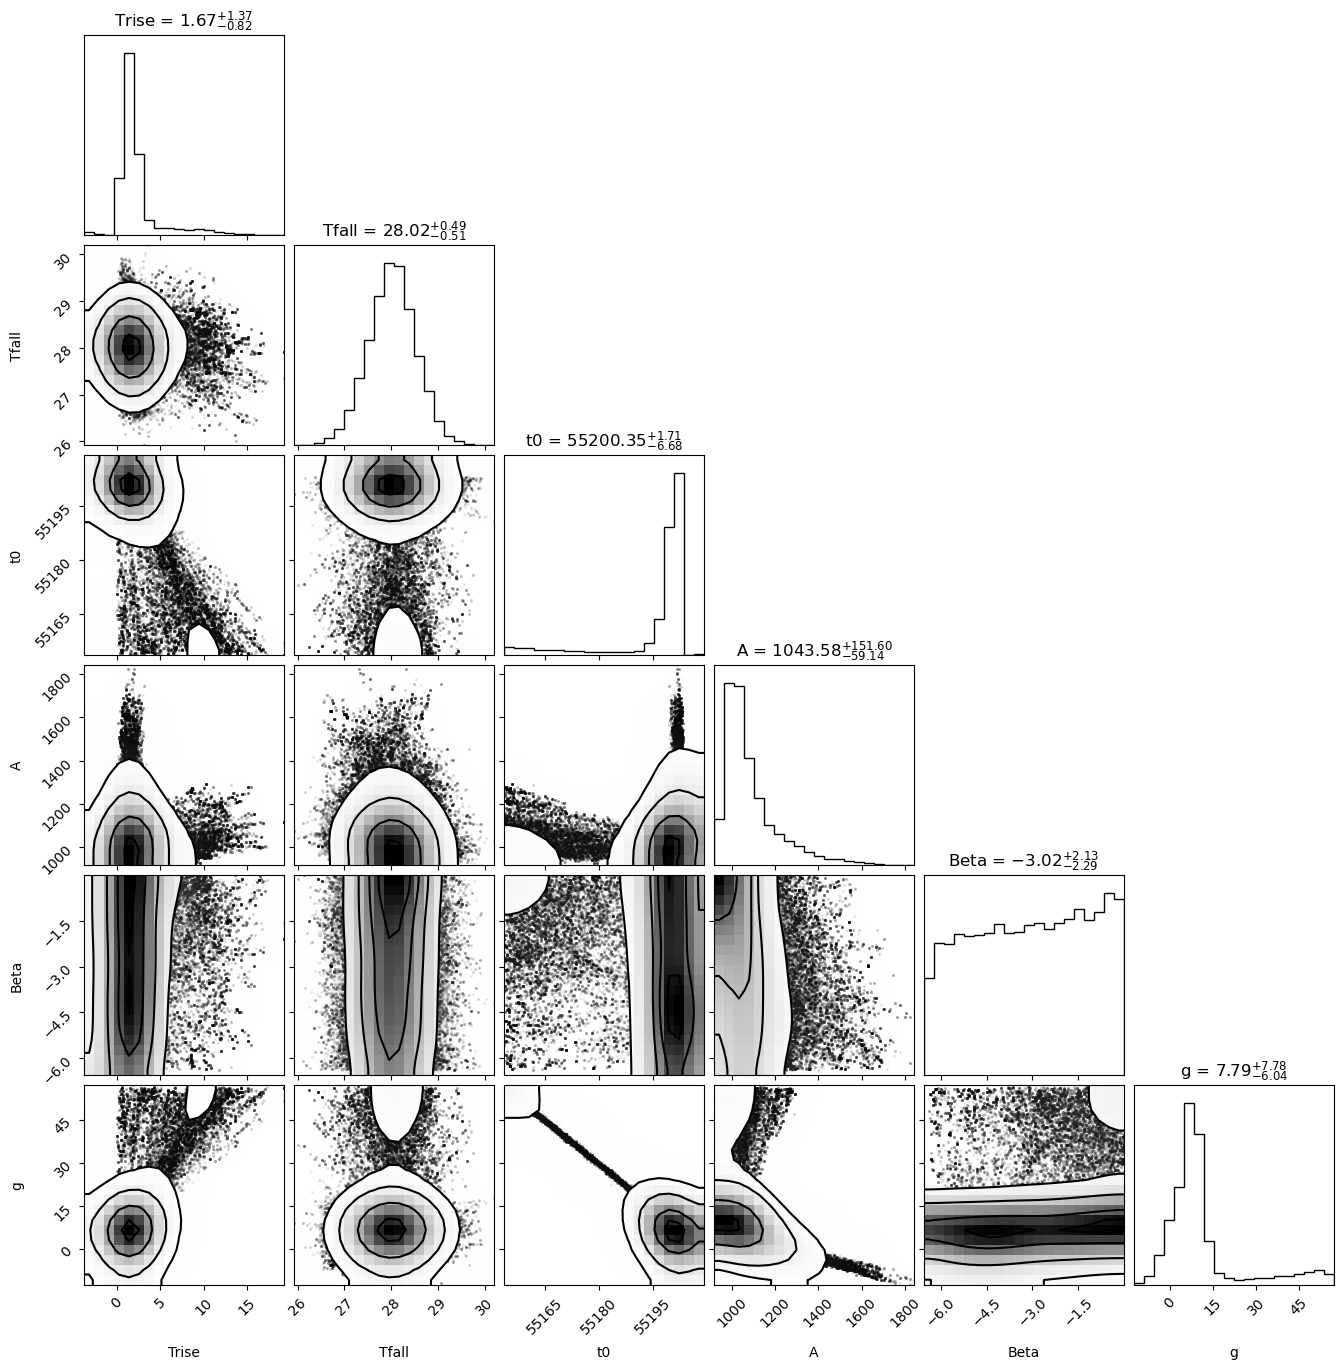

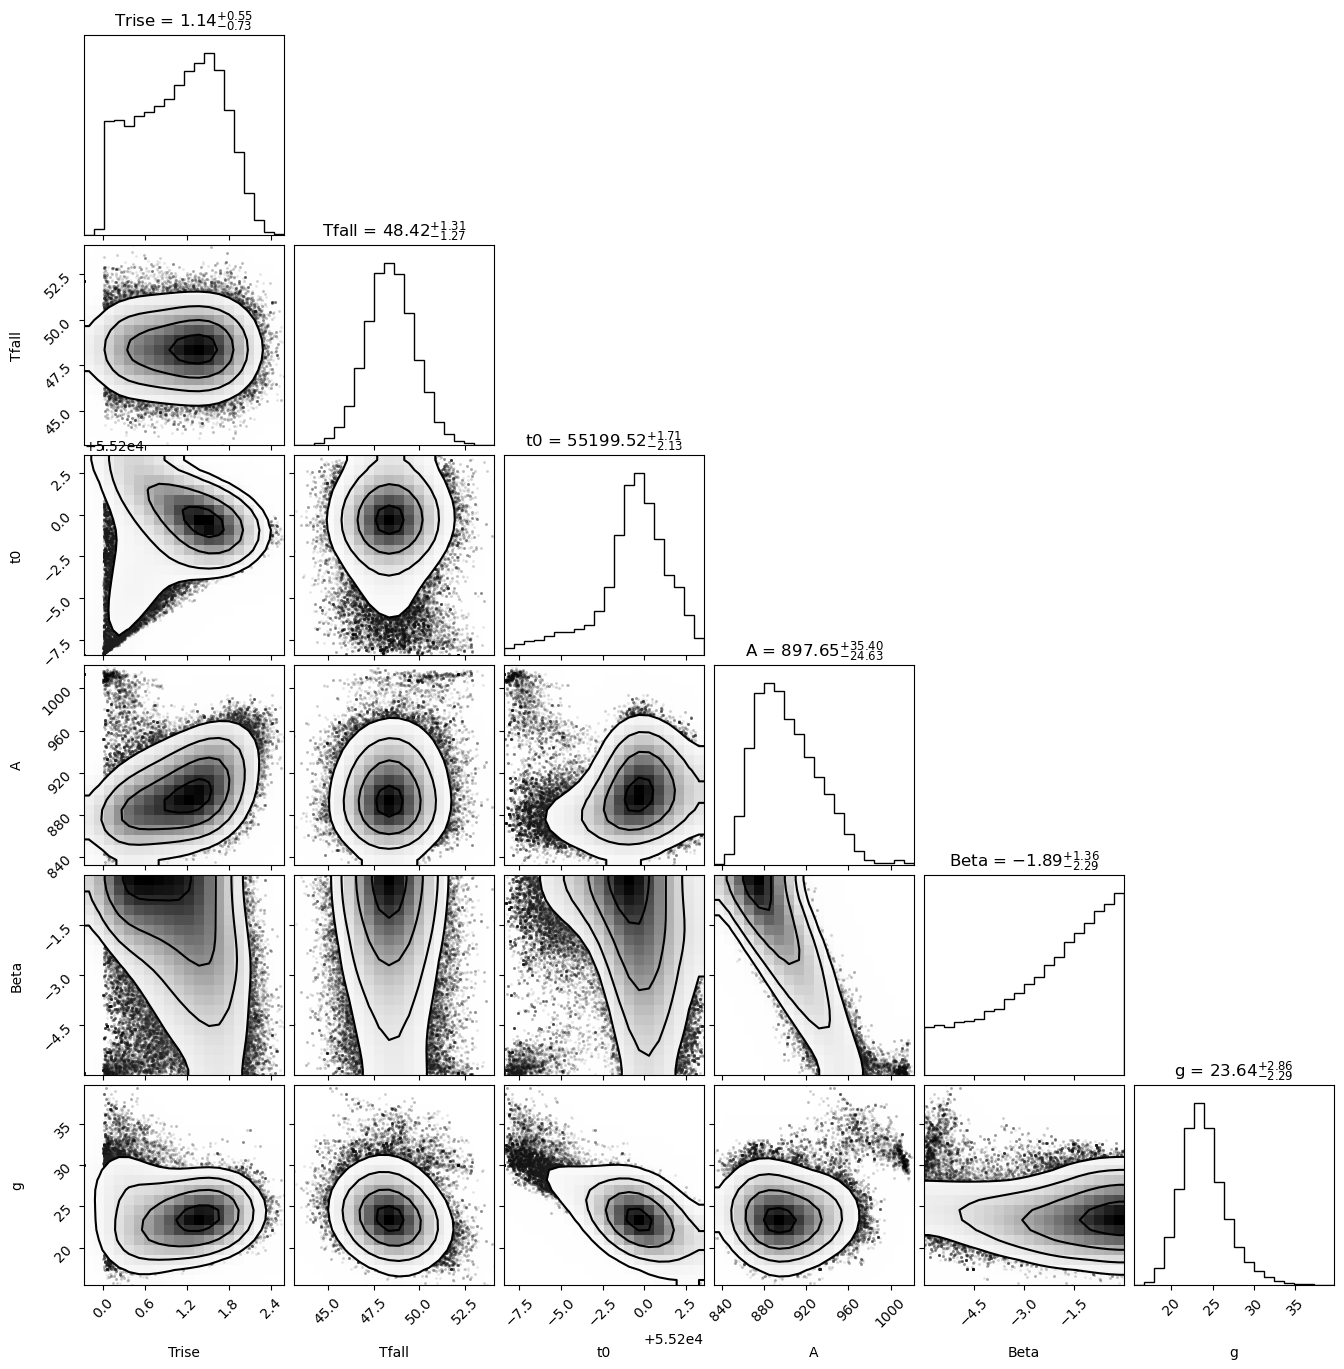

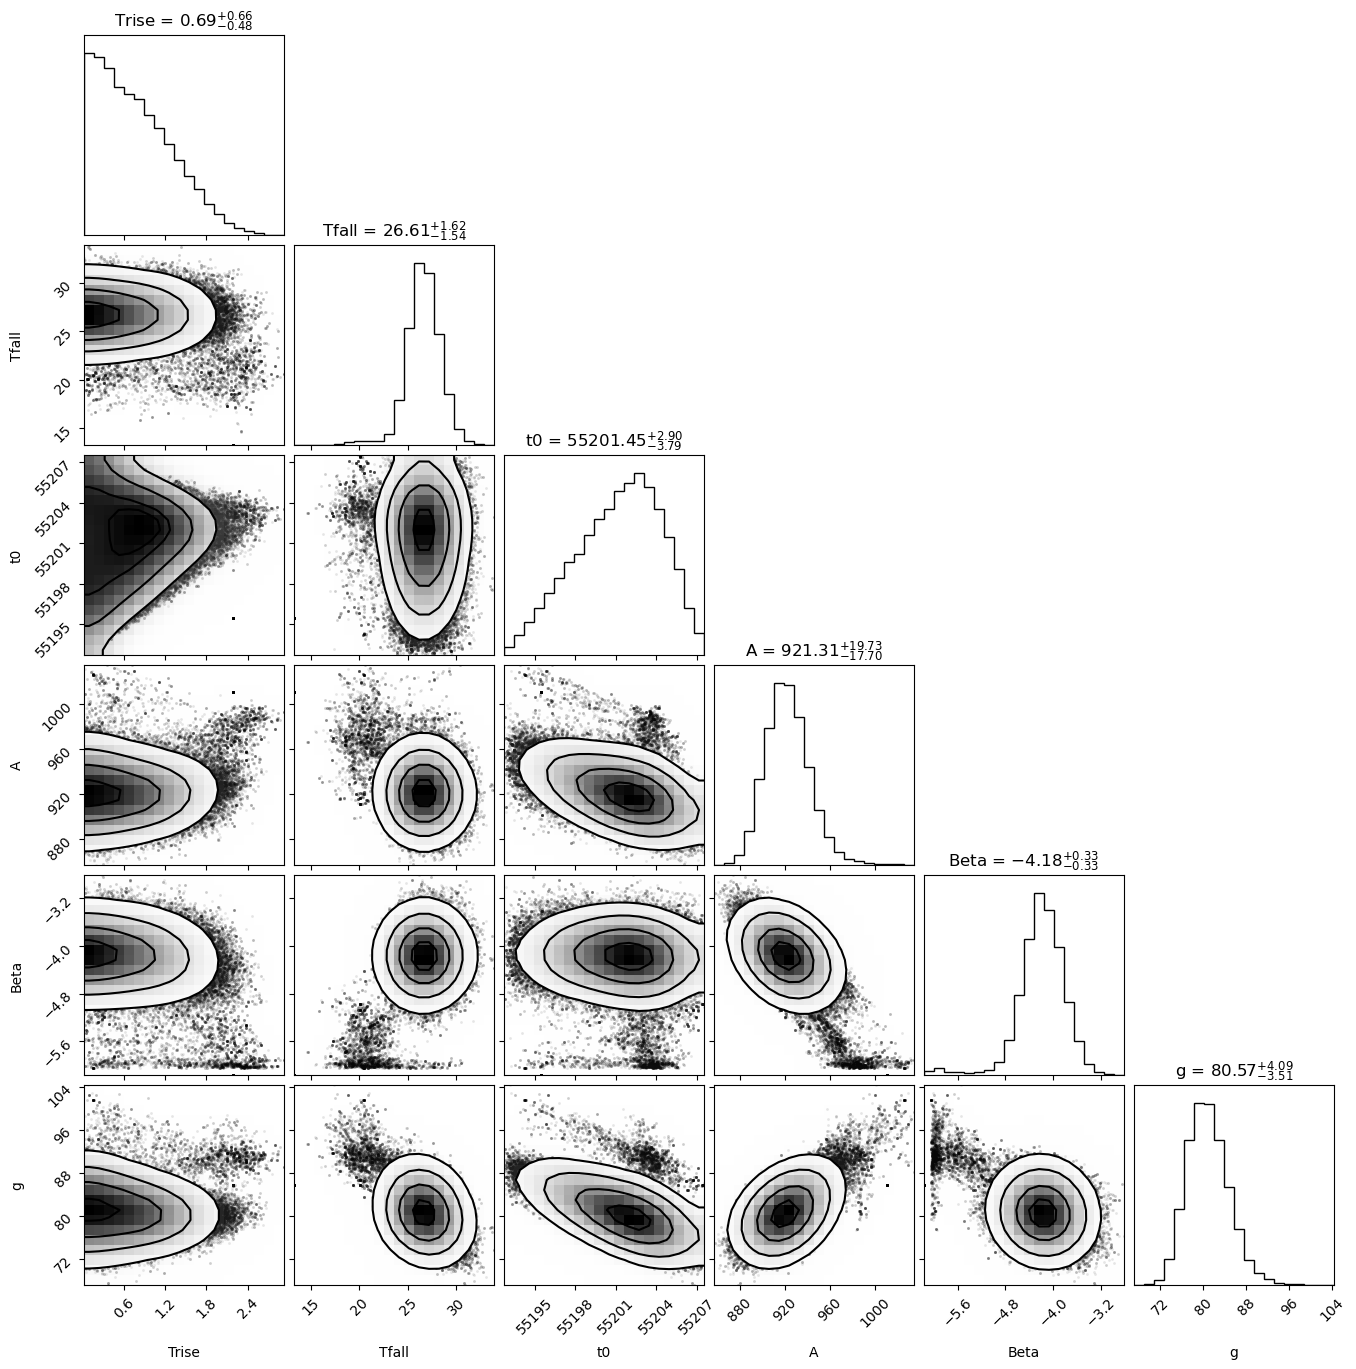

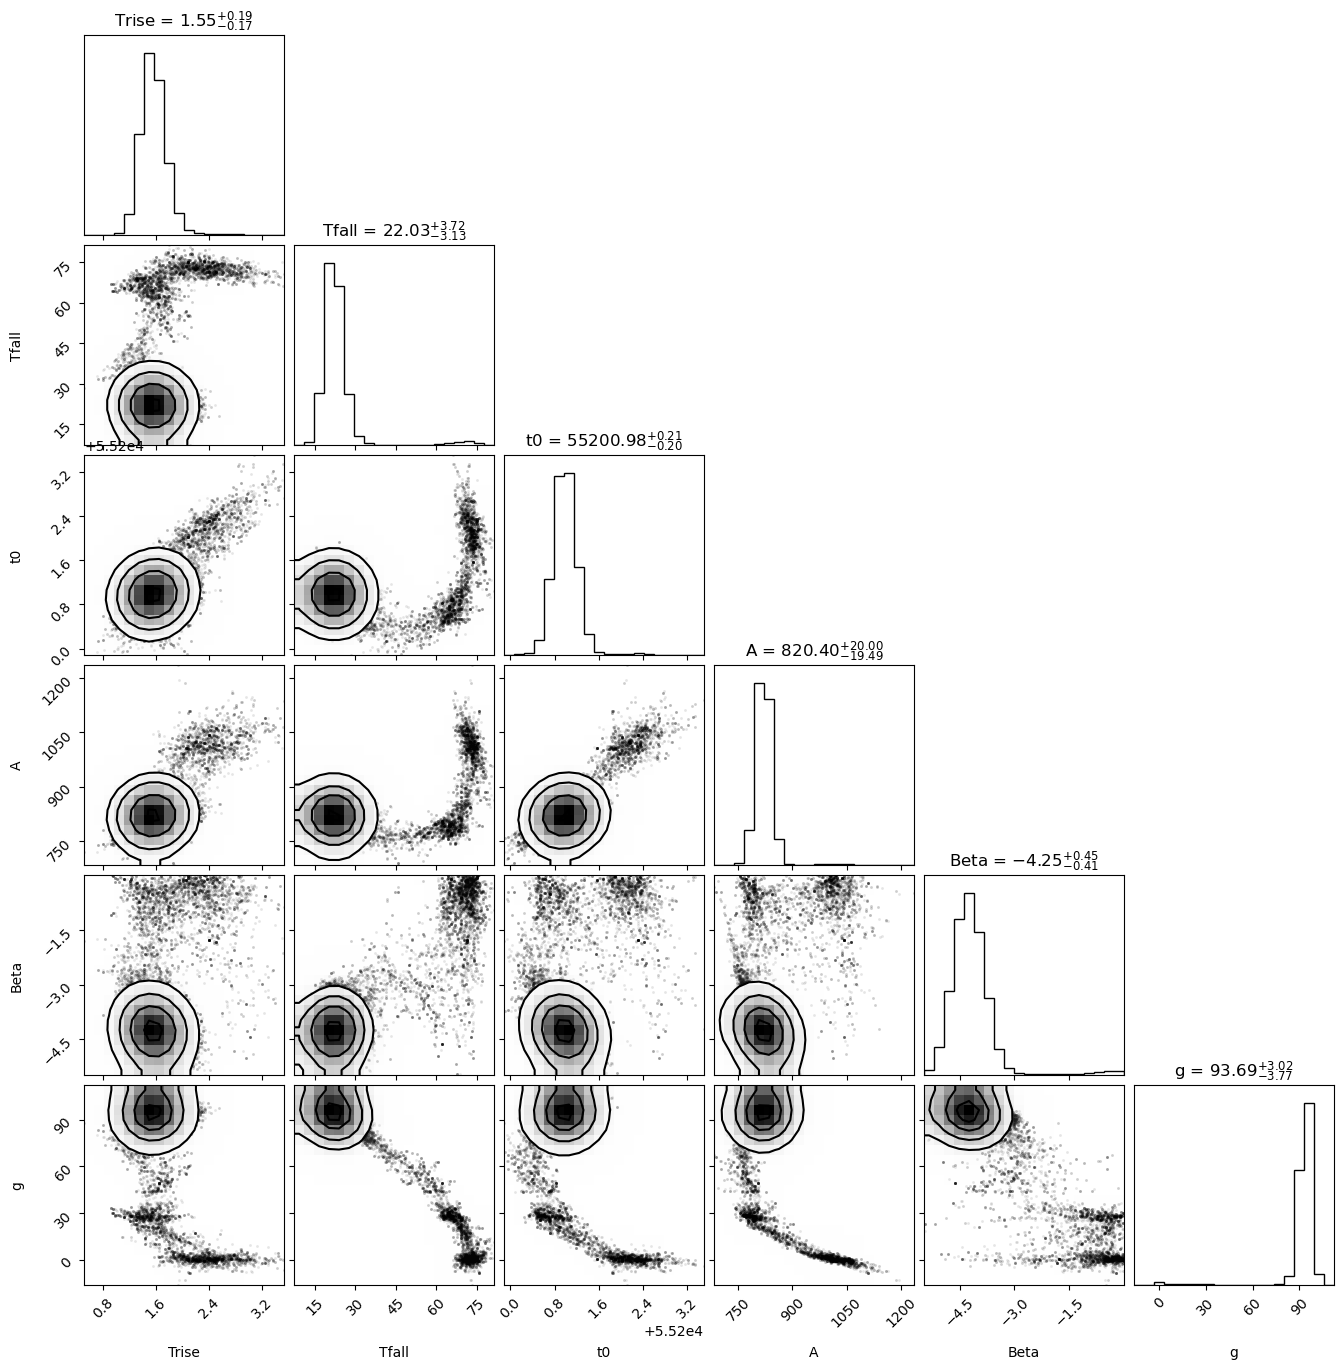

In [64]:
#samples = sampler.get_chain(flat=True) # you can flatten the chain - essentially concatenate the walkers
#samples.shape
#[Trise, Tfall, t0, A, Beta, g: (t1-t0)]
labels=['Trise', 'Tfall', 't0', 'A', 'Beta', 'g']
filter_order = ['g', 'r', 'i', 'z']
#fig = corner.corner(samples[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)
for i in range(4):
    samp_curr = samples_98[i]
    fig = corner.corner(samp_curr[nburn:,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)
    fig.savefig('Corner_plot_PS1_PS1MD_PSc000098_filter_'+filter_order[i]+'.png')

In [60]:
nwalkers = 20
nburn = 1000
nsteps = 10000



#theta174 = np.array([3.64090728e-01, 2.80724949e+01, 5.52028413e+04, 1.01975704e+03, -6.38325245e+00, 5.79131237e+00])

#starting_guesses = np.zeros((nwalkers, ndim))
#starting_guesses = np.random.normal(theta98, 3, (nwalkers, ndim))
#starting_guesses = theta174 + 0.1*sigmas*np.random.randn(nwalkers, ndim)

samples_174 = []

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[File_98_MJD[0], File_98_flux[0], File_98_fluxerr[0]])
#_= sampler.run_mcmc(starting_guesses, nsteps)
for i in range(4):
    
    guess = (2.14, 28.02, 55197.74, 300, -2.44, 11.12)
    args = (File_174_MJD[i], File_174_flux[i], File_174_fluxerr[i])
    bounds = [(0, 50), (1, 300), (np.min(File_174_MJD[i])-50, np.max(File_174_MJD[i])+300), (0, 100*np.max(File_174_flux[i])), (-np.max(File_174_flux[i])/150, 0), (0, 200)]

    res = so.minimize(chisq, guess, args=args, bounds=bounds)
    #print(res.x)
    sigmas = np.diag(res.hess_inv.todense())**0.5
    
    starting_guesses = res.x + 0.1*sigmas*np.random.randn(nwalkers, ndim)
    
    sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[File_174_MJD[i], File_174_flux[i], File_174_fluxerr[i]])
    _ = sampler2.run_mcmc(starting_guesses, nsteps)
    samples = sampler2.get_chain(flat=True)
    samples_174.append(samples)
    print(i)

/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1685408755.py:19: RuntimeWarning: overflow encountered in exp
  F_mod[mask2] = np.nan_to_num(((A+Beta*(t1-t0))/(1+np.exp(-1*(t[mask2]-t0)/Trise)))*np.exp(-1*(t[mask2]-t1)/Tfall))
/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1685408755.py:18: RuntimeWarning: overflow encountered in exp
  F_mod[mask] = np.nan_to_num((A+Beta*(t[mask]-t0))/(1+np.exp(-1*(t[mask]-t0)/Trise)))


0
1
2


/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1685408755.py:18: RuntimeWarning: divide by zero encountered in divide
  F_mod[mask] = np.nan_to_num((A+Beta*(t[mask]-t0))/(1+np.exp(-1*(t[mask]-t0)/Trise)))
/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1685408755.py:19: RuntimeWarning: divide by zero encountered in divide
  F_mod[mask2] = np.nan_to_num(((A+Beta*(t1-t0))/(1+np.exp(-1*(t[mask2]-t0)/Trise)))*np.exp(-1*(t[mask2]-t1)/Tfall))
/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1685408755.py:69: RuntimeWarning: overflow encountered in square
  chisq = np.sum(((F - mod)**2.)/(sigma_F**2.))
/var/folders/cd/fndjqcy97zn17y2c0b1hzt840000gn/T/ipykernel_3645/1685408755.py:19: RuntimeWarning: overflow encountered in multiply
  F_mod[mask2] = np.nan_to_num(((A+Beta*(t1-t0))/(1+np.exp(-1*(t[mask2]-t0)/Trise)))*np.exp(-1*(t[mask2]-t1)/Tfall))


3


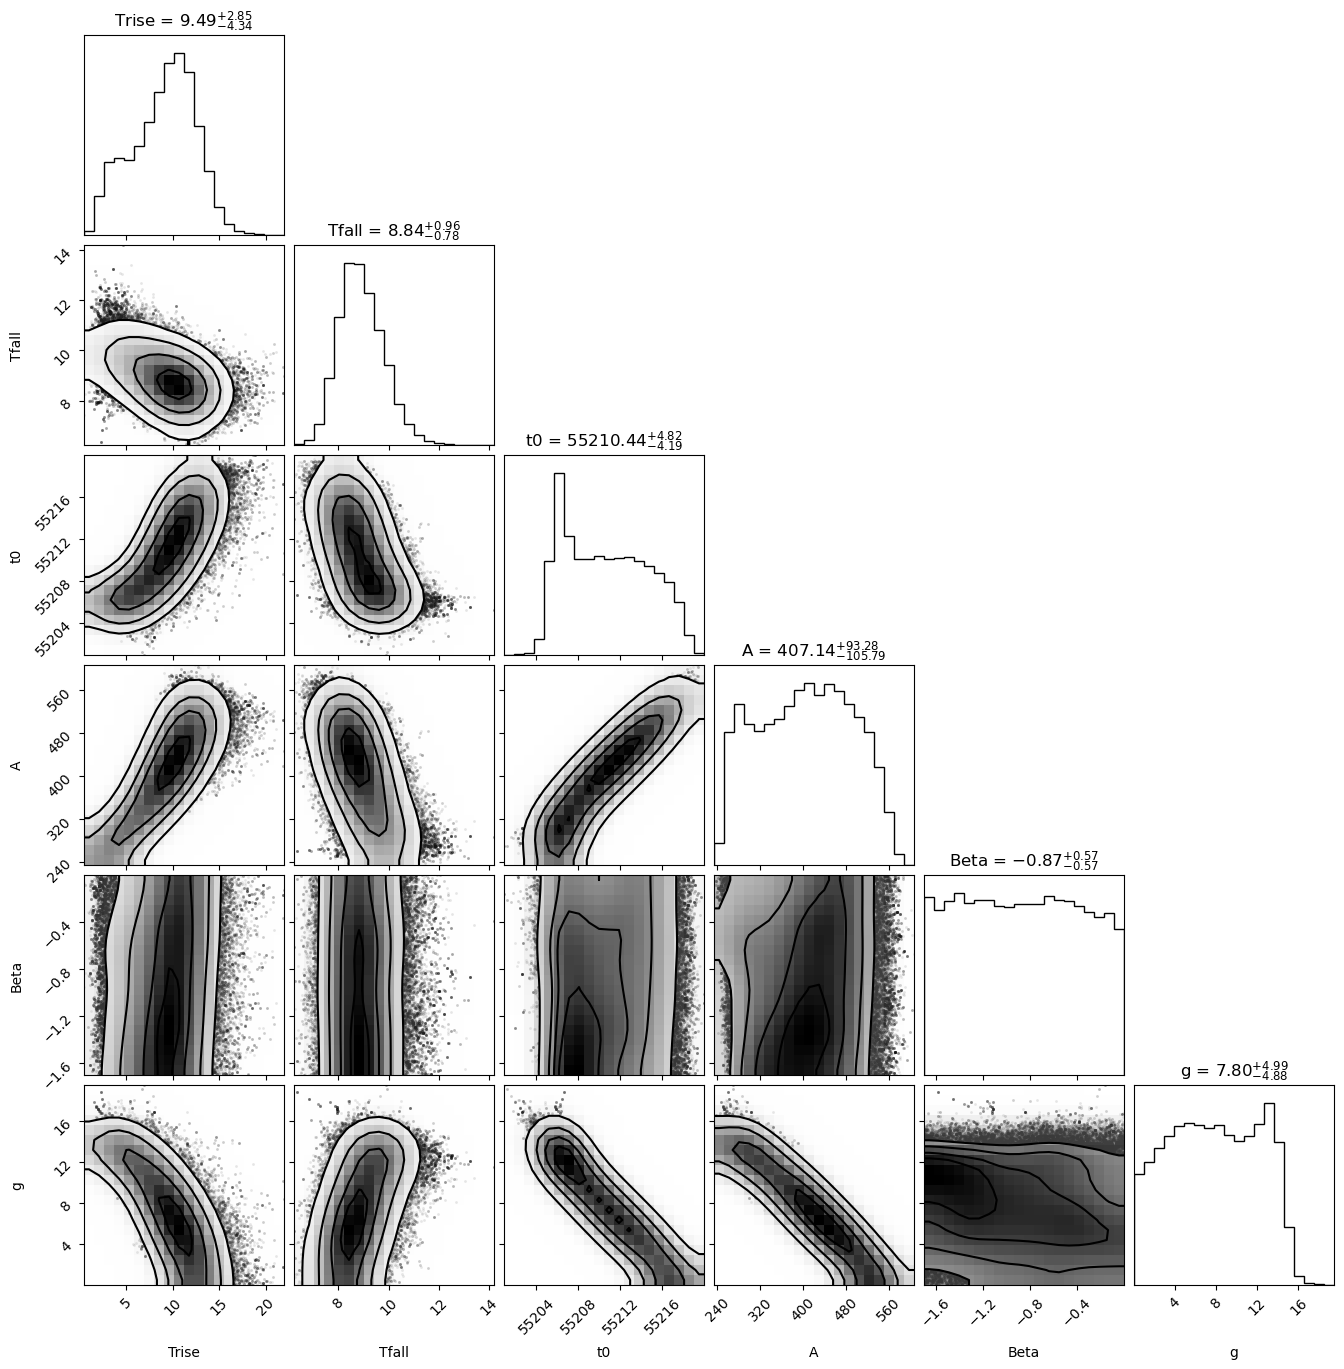

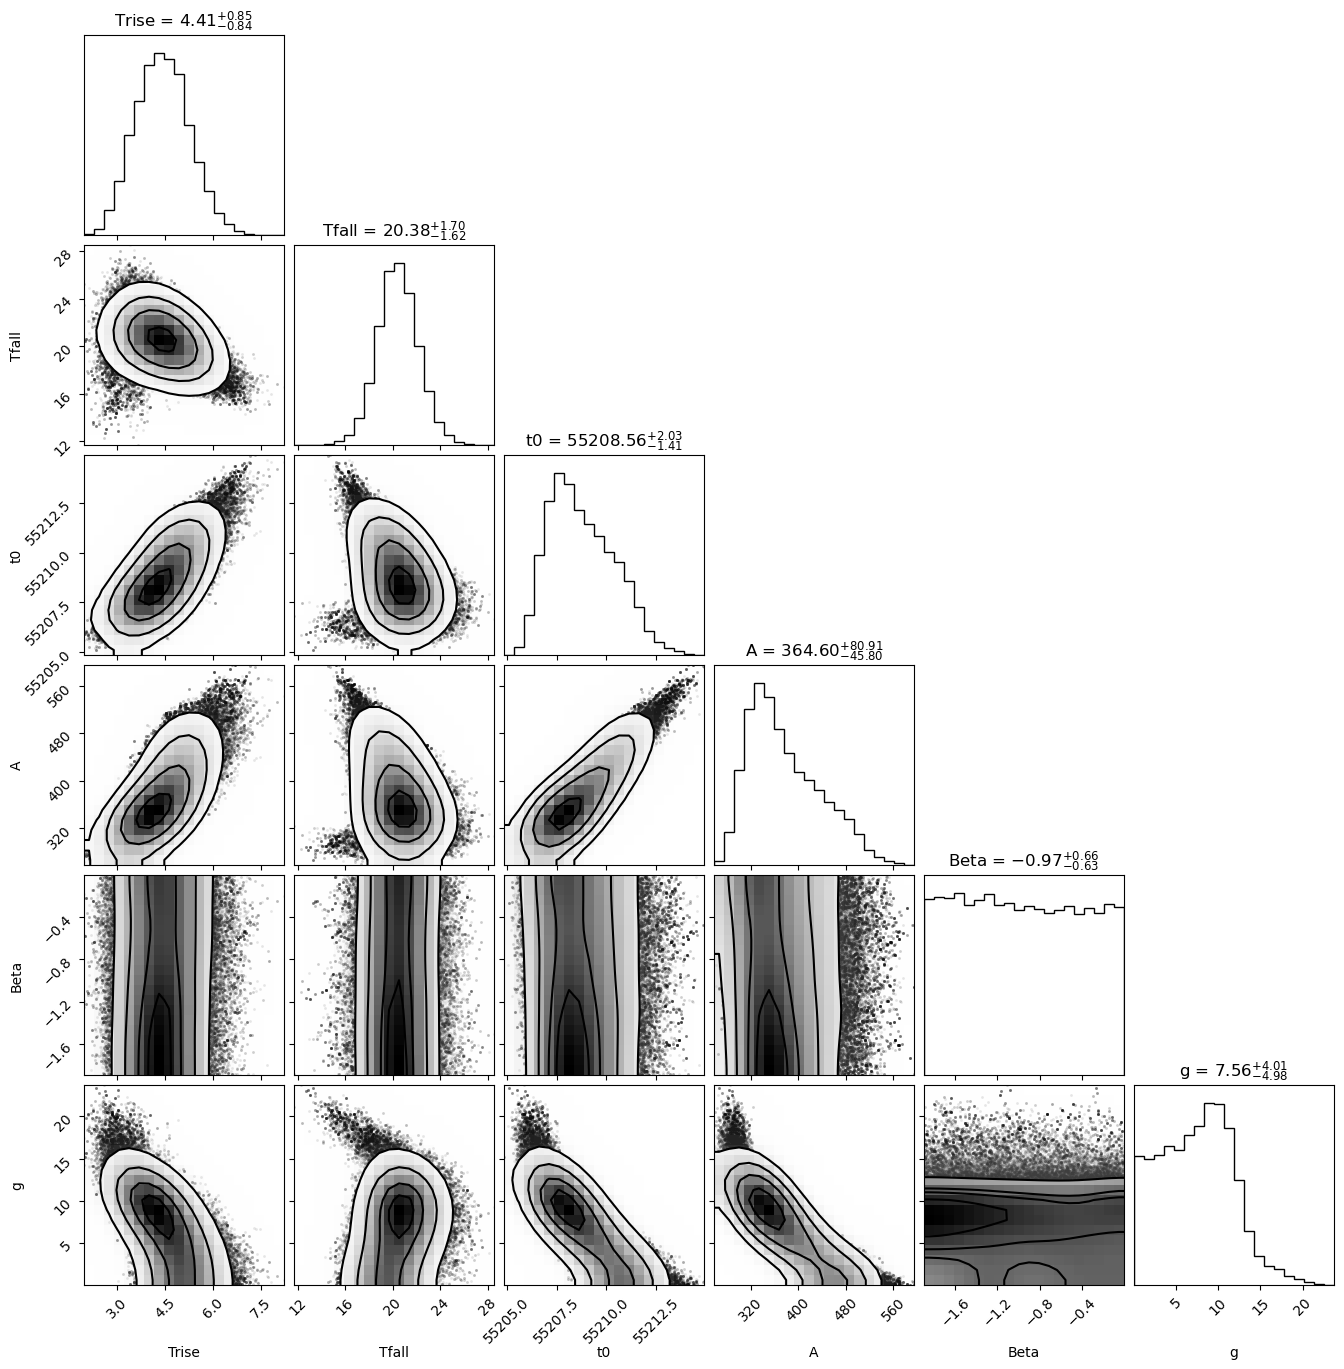

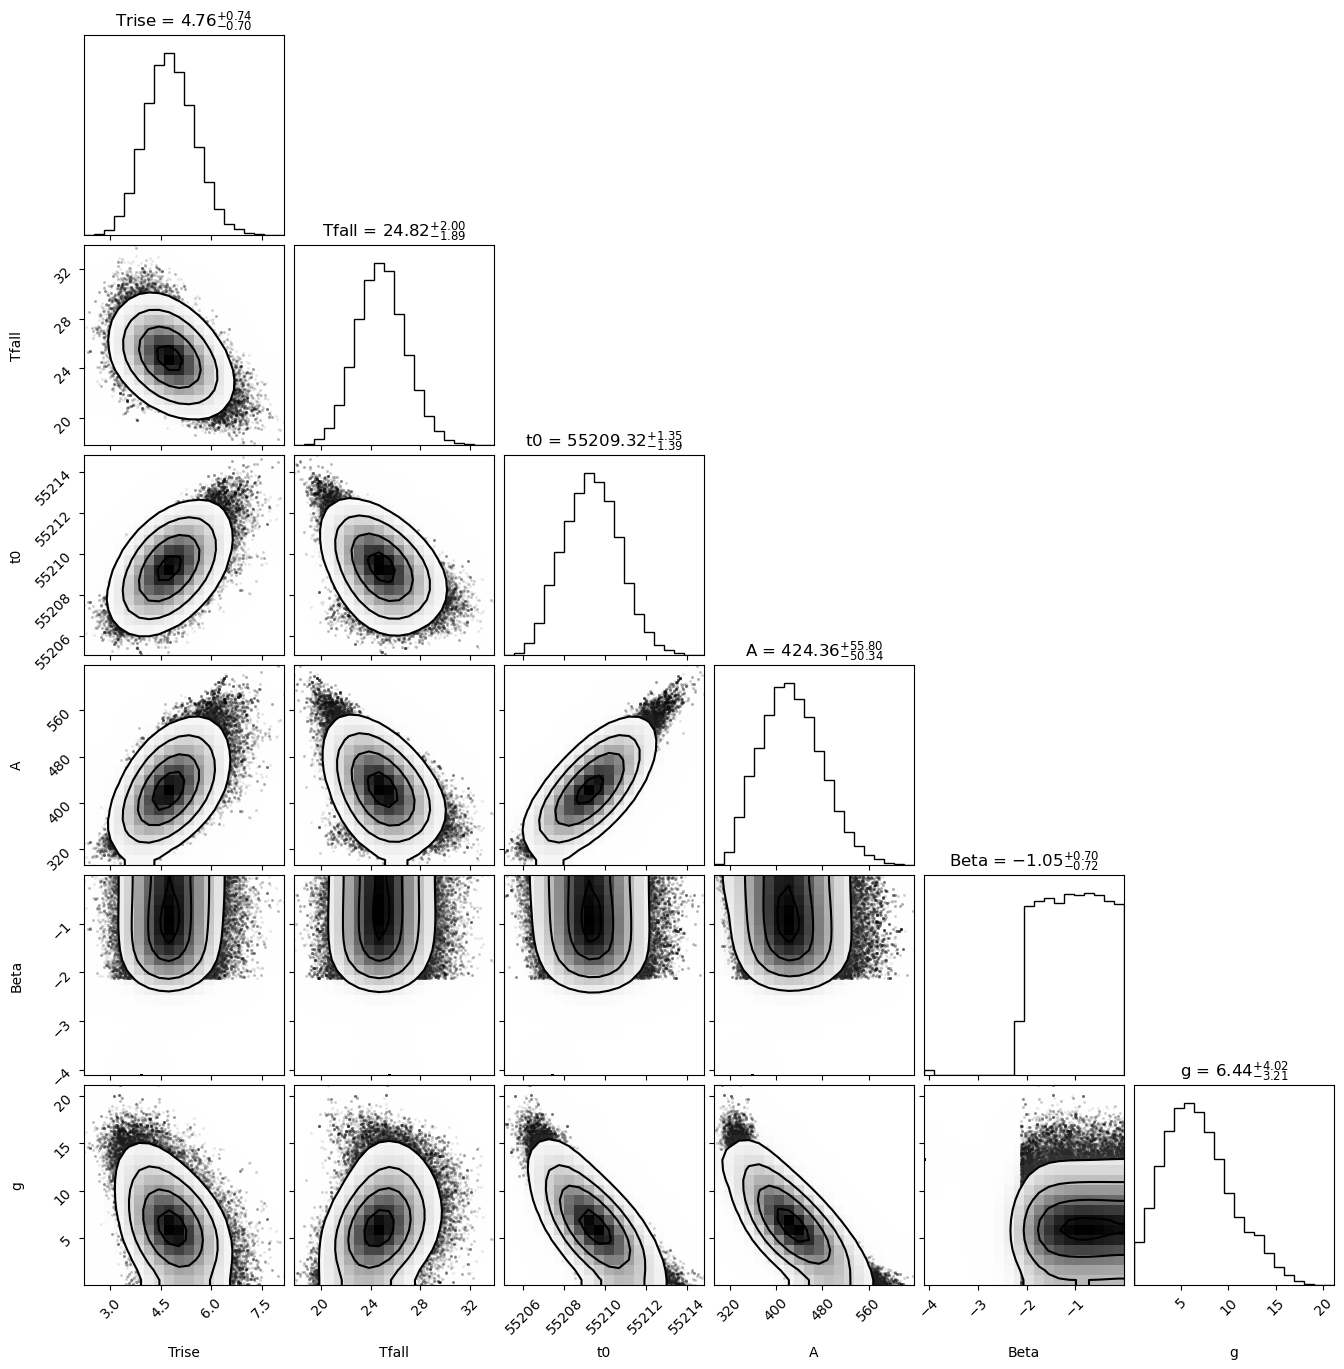

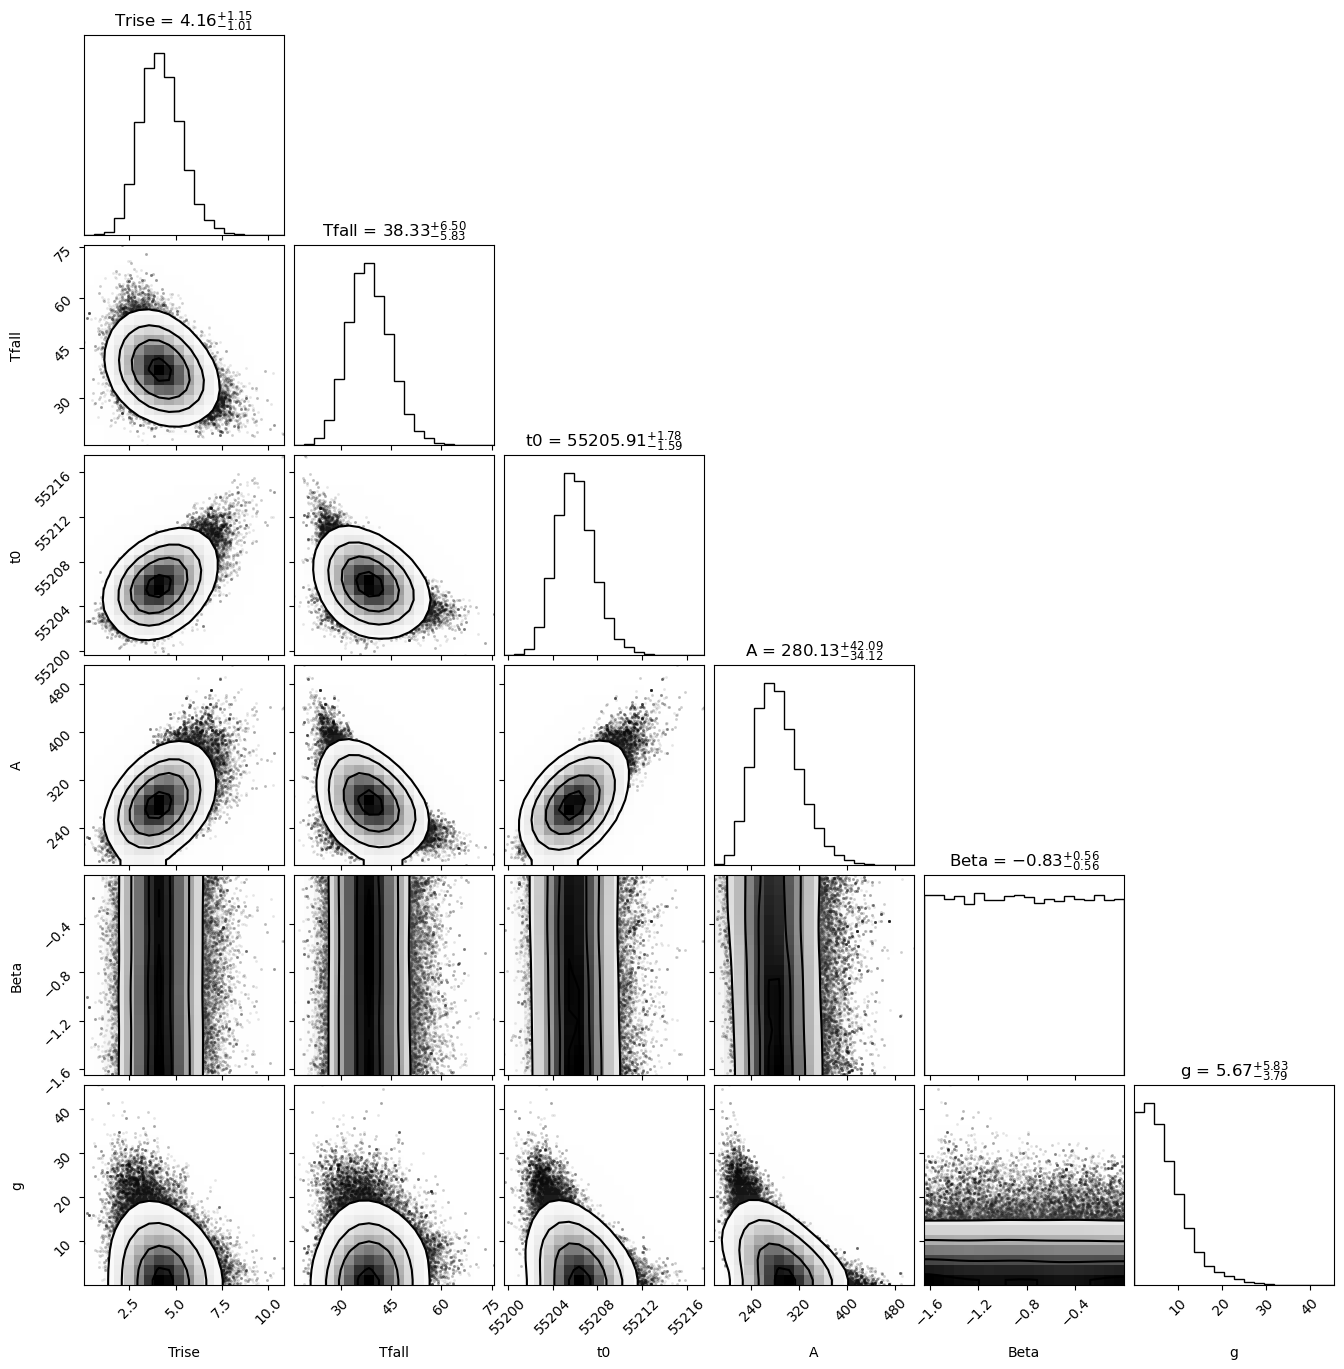

In [61]:
labels=['Trise', 'Tfall', 't0', 'A', 'Beta', 'g']
filter_order = ['g', 'r', 'i', 'z']
#fig = corner.corner(samples[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)
for i in range(4):
    samp_curr = samples_174[i]
    fig = corner.corner(samp_curr[nburn:,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)
    fig.savefig('Corner_plot_PS1_PS1MD_PSc000174_filter_'+filter_order[i]+'.png')

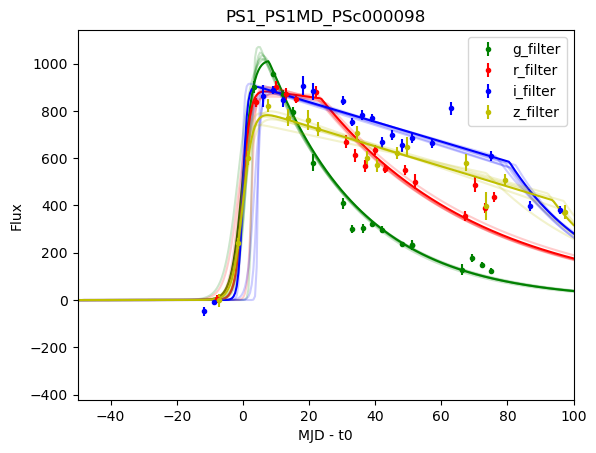

In [78]:
#98 plot

#[Trise, Tfall, t0, A, Beta, g: (t1-t0)]
fmt_list = ['g.', 'r.', 'b.', 'y.']
color_list = ['g', 'r', 'b', 'y']
label_list = ['g_filter', 'r_filter', 'i_filter', 'z_filter']
t_model = np.linspace(-50, 100, 300)
for i in range(4):
    samp_curr = samples_98[i]
    Trise = np.median(samp_curr[nburn:,0])
    Tfall = np.median(samp_curr[nburn:,1])
    t0 = np.median(samp_curr[nburn:,2])
    A = np.median(samp_curr[nburn:,3])
    Beta = np.median(samp_curr[nburn:,4])
    g = np.median(samp_curr[nburn:,5])
    var_list = [Trise, Tfall, t0, A, Beta, g]
    F_model = model(var_list, t_model+t0)
    
    plt.errorbar(File_98_MJD[i] - t0, File_98_flux[i], File_98_fluxerr[i], fmt=fmt_list[i], label=label_list[i])
    plt.plot(t_model, F_model, color_list[i])
    rand_var = np.random.randint(len(samp_curr[nburn:,0]), size=5)
    #print(rand_var)
    for j in range(5):
        var_list_spr = [samp_curr[nburn+rand_var[j],0], samp_curr[nburn+rand_var[j],1], samp_curr[nburn+rand_var[j],2], 
                       samp_curr[nburn+rand_var[j],3], samp_curr[nburn+rand_var[j],4], samp_curr[nburn+rand_var[j],5]]
        F_spr = model(var_list_spr, t_model+t0)
        plt.plot(t_model, F_spr, color_list[i], alpha=0.2)
plt.xlim(-50,100)
plt.title('PS1_PS1MD_PSc000098')
plt.xlabel('MJD - t0')
plt.ylabel('Flux')
plt.legend()
plt.savefig('Ashley_plot_PS1_PS1MD_PSc000098.png')
plt.show()
    
    

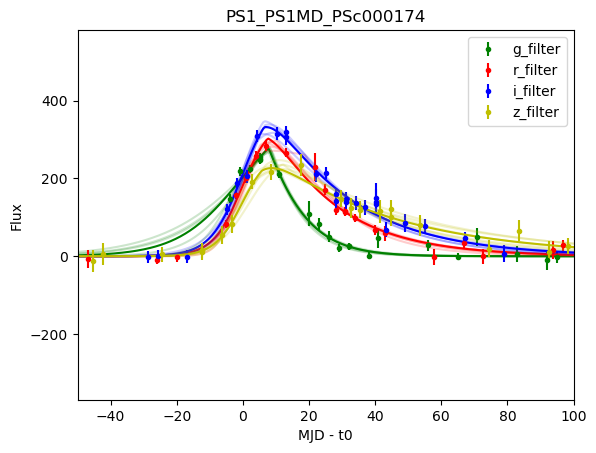

In [79]:
#174 plot

#[Trise, Tfall, t0, A, Beta, g: (t1-t0)]
fmt_list = ['g.', 'r.', 'b.', 'y.']
color_list = ['g', 'r', 'b', 'y']
label_list = ['g_filter', 'r_filter', 'i_filter', 'z_filter']
t_model = np.linspace(-50, 100, 300)
for i in range(4):
    samp_curr = samples_174[i]
    Trise = np.median(samp_curr[nburn:,0])
    Tfall = np.median(samp_curr[nburn:,1])
    t0 = np.median(samp_curr[nburn:,2])
    A = np.median(samp_curr[nburn:,3])
    Beta = np.median(samp_curr[nburn:,4])
    g = np.median(samp_curr[nburn:,5])
    var_list = [Trise, Tfall, t0, A, Beta, g]
    F_model = model(var_list, t_model+t0)
    
    plt.errorbar(File_174_MJD[i] - t0, File_174_flux[i], File_174_fluxerr[i], fmt=fmt_list[i], label=label_list[i])
    plt.plot(t_model, F_model, color_list[i])
    rand_var = np.random.randint(len(samp_curr[nburn:,0]), size=5)
    #print(rand_var)
    for j in range(5):
        var_list_spr = [samp_curr[nburn+rand_var[j],0], samp_curr[nburn+rand_var[j],1], samp_curr[nburn+rand_var[j],2], 
                       samp_curr[nburn+rand_var[j],3], samp_curr[nburn+rand_var[j],4], samp_curr[nburn+rand_var[j],5]]
        F_spr = model(var_list_spr, t_model+t0)
        plt.plot(t_model, F_spr, color_list[i], alpha=0.2)
plt.xlim(-50,100)
plt.title('PS1_PS1MD_PSc000174')
plt.xlabel('MJD - t0')
plt.ylabel('Flux')
plt.legend()
plt.savefig('Ashley_plot_PS1_PS1MD_PSc000174.png')
plt.show()

PS1_PS1MD_PSc000098 auto correlation plots


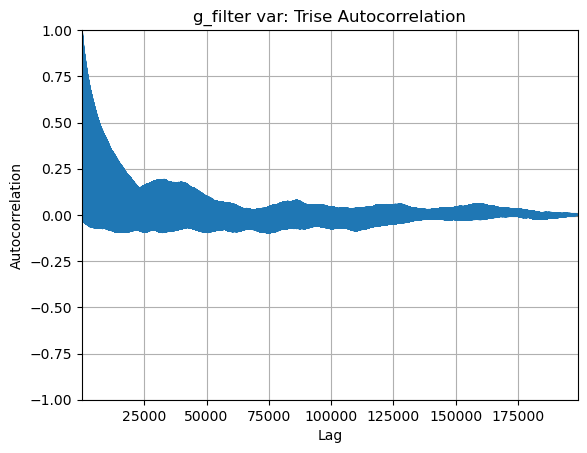

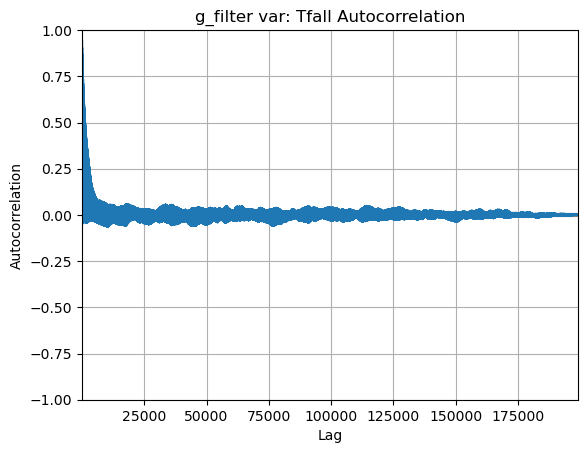

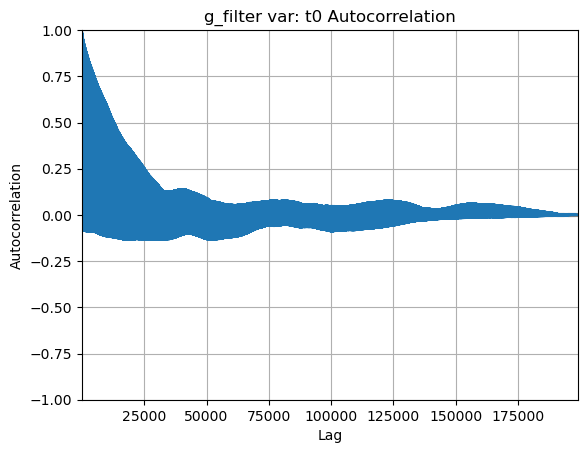

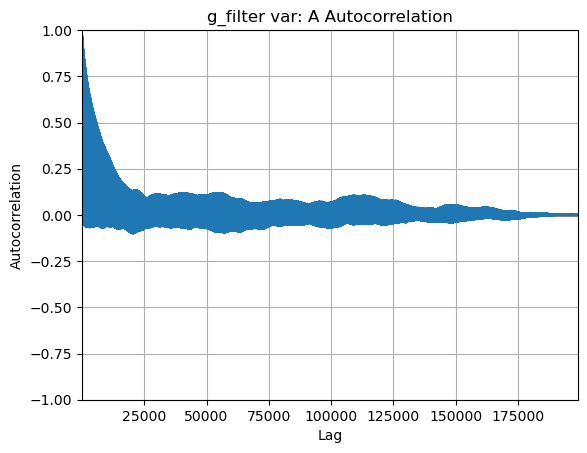

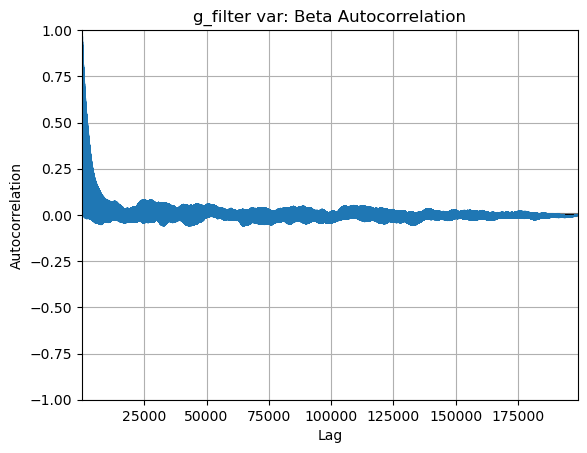

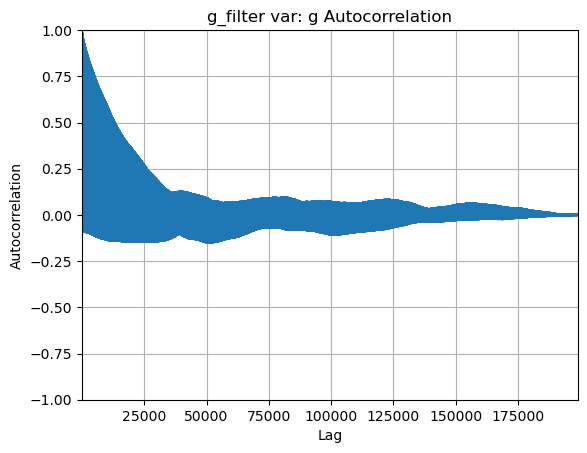

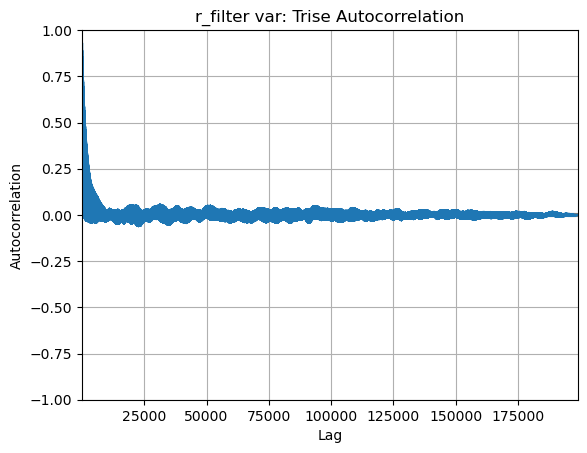

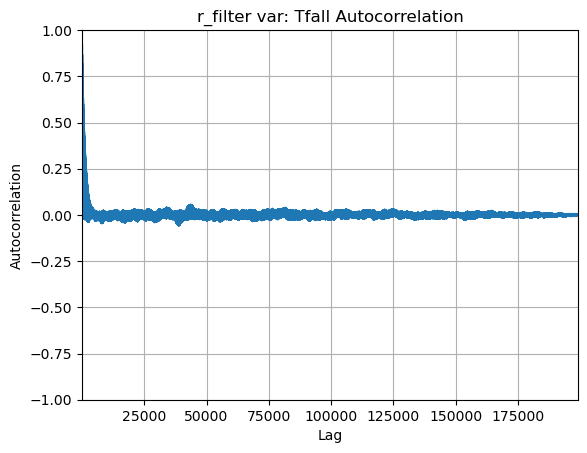

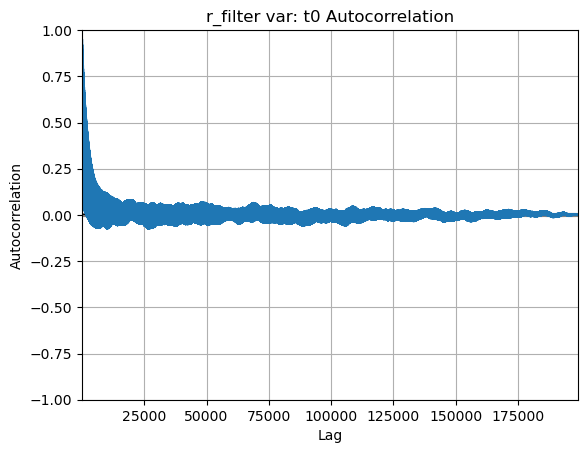

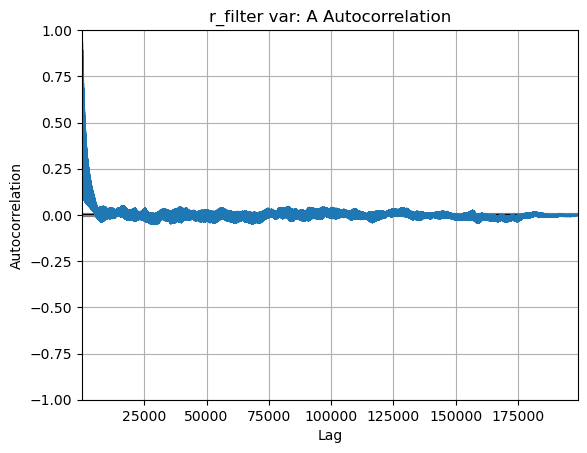

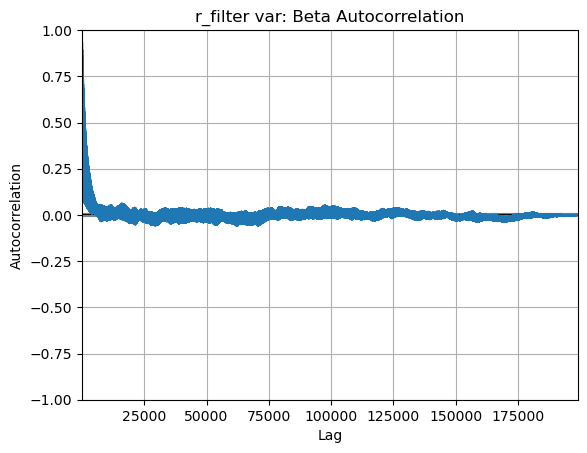

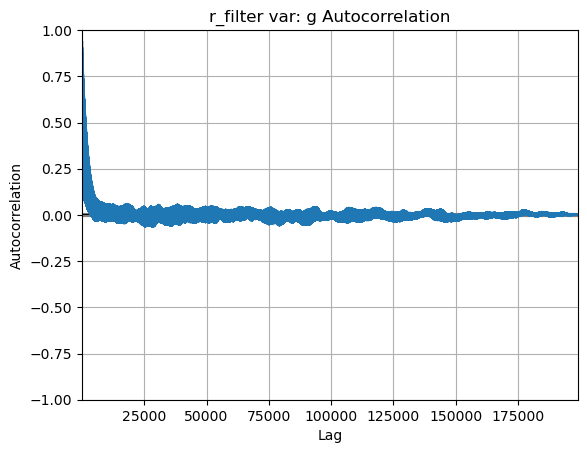

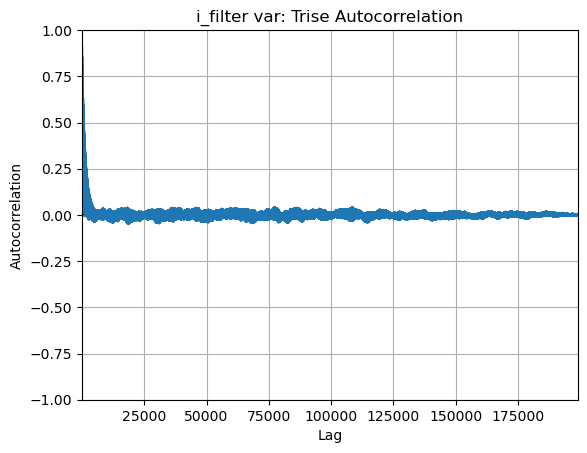

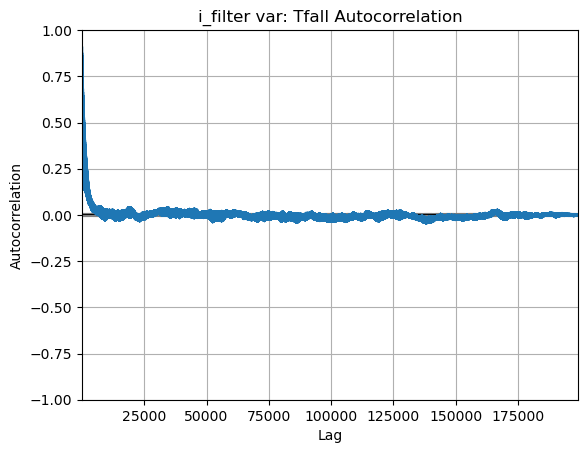

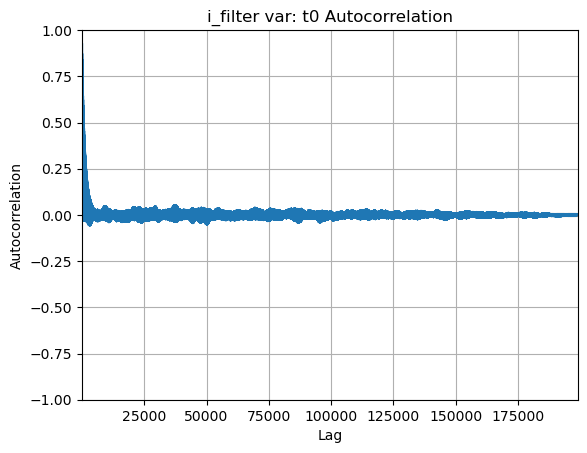

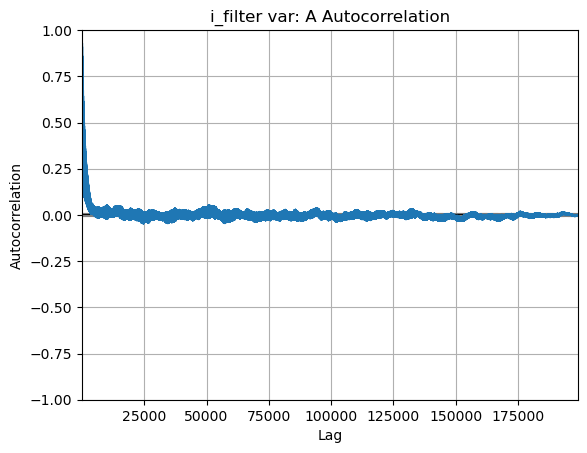

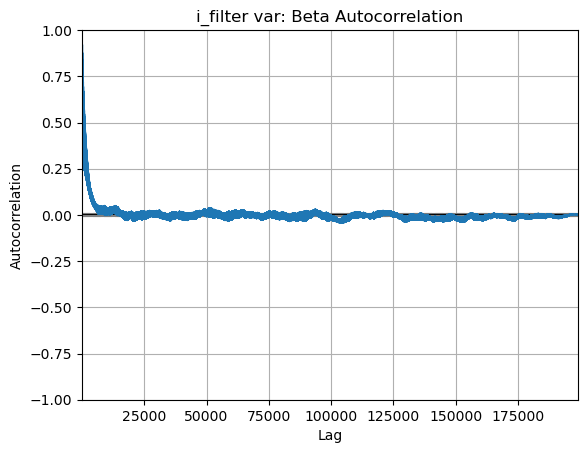

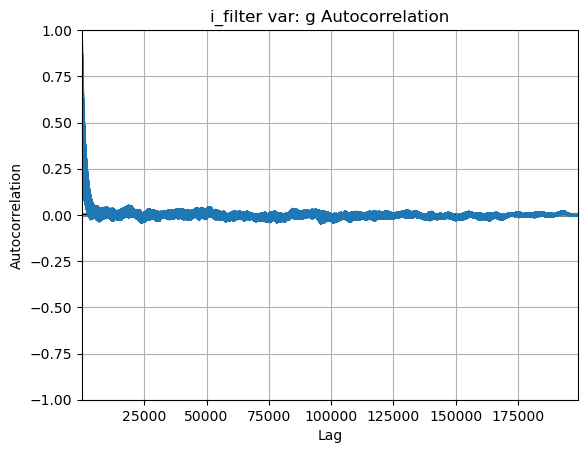

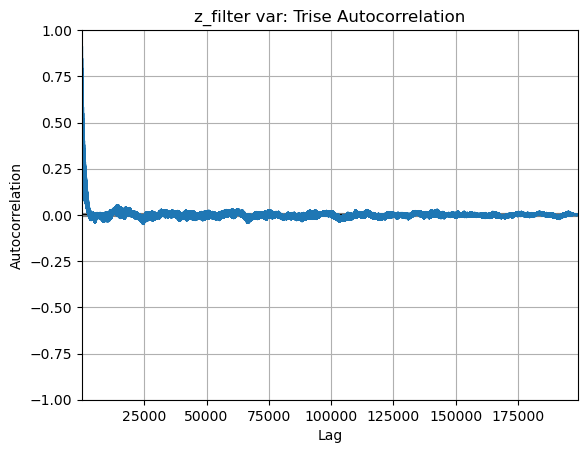

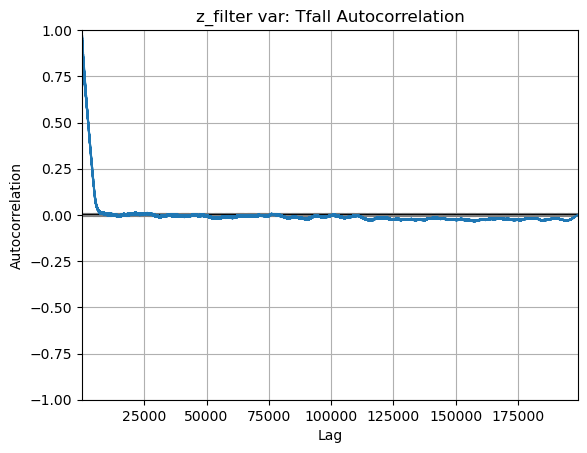

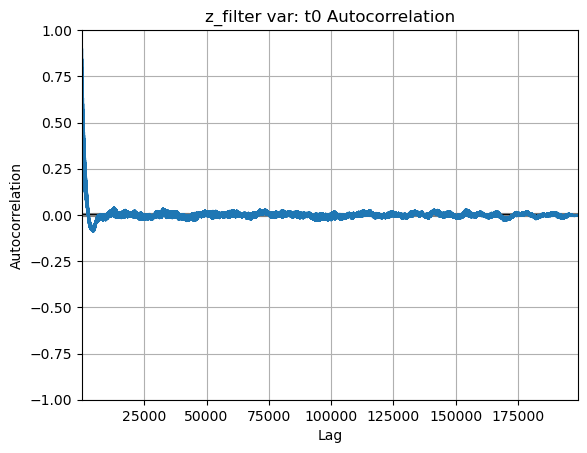

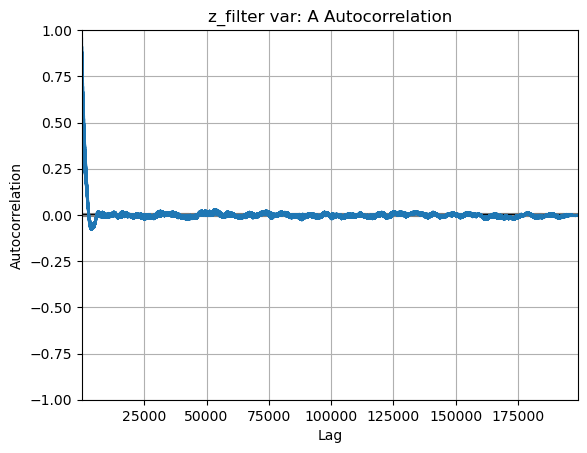

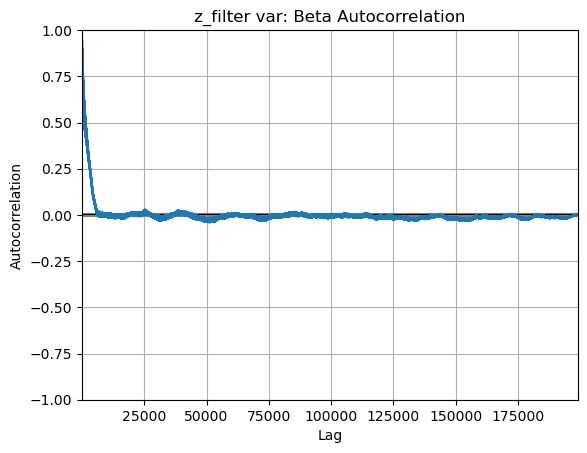

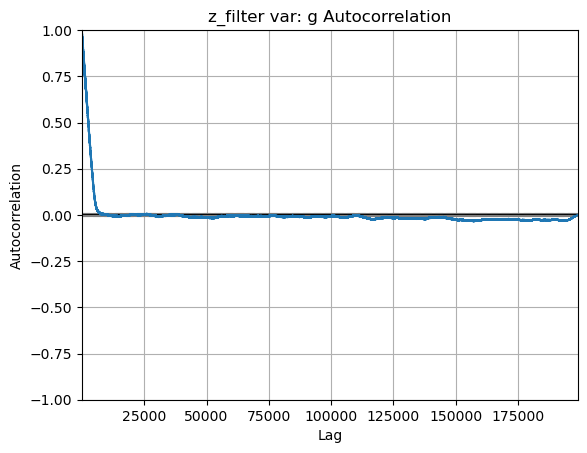

In [86]:
#auto correlation
# 98
print('PS1_PS1MD_PSc000098 auto correlation plots')
label_list = ['g_filter', 'r_filter', 'i_filter', 'z_filter']
var_list = ['Trise', 'Tfall', 't0', 'A', 'Beta', 'g']
for i in range(4):
    samp_curr = samples_98[i]
    for j in range(6):
        pd.plotting.autocorrelation_plot(samp_curr[nburn:,j])
        plt.title(label_list[i]+' var: '+var_list[j]+' Autocorrelation')
        plt.show()

PS1_PS1MD_PSc000098 auto correlation plots, thinned by factor of 10


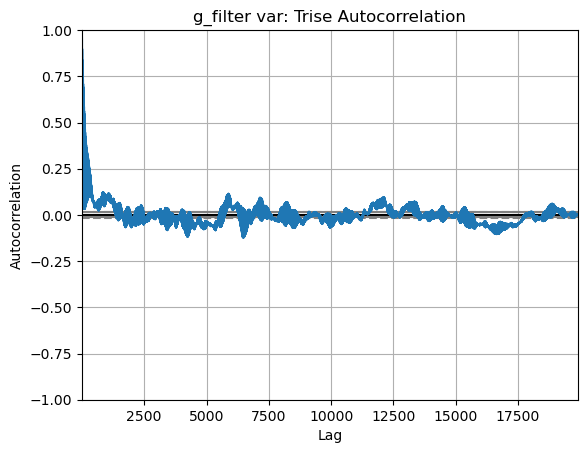

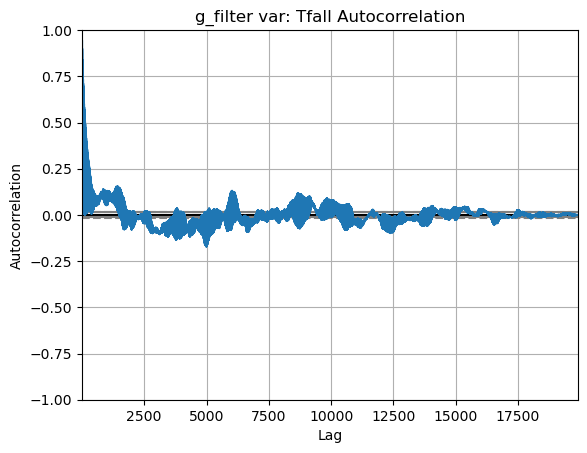

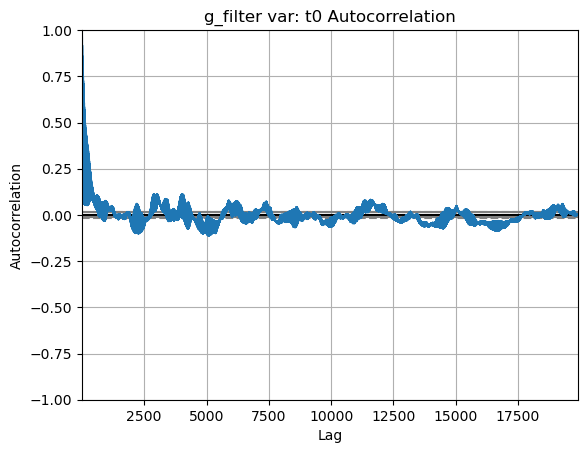

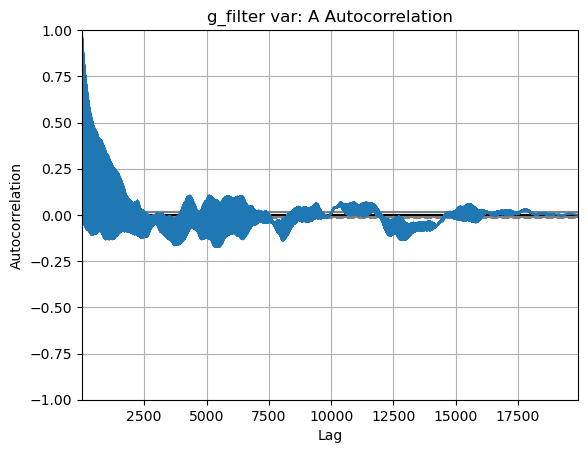

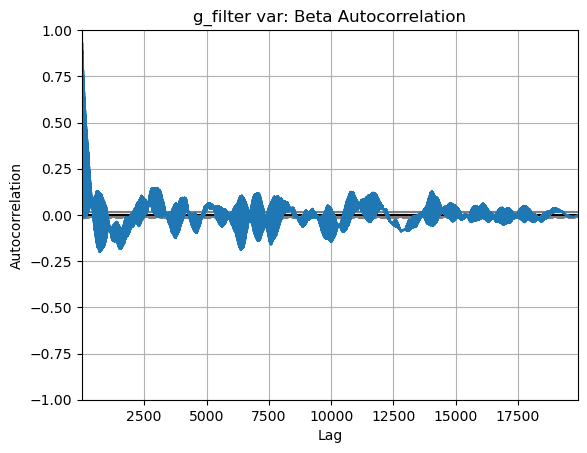

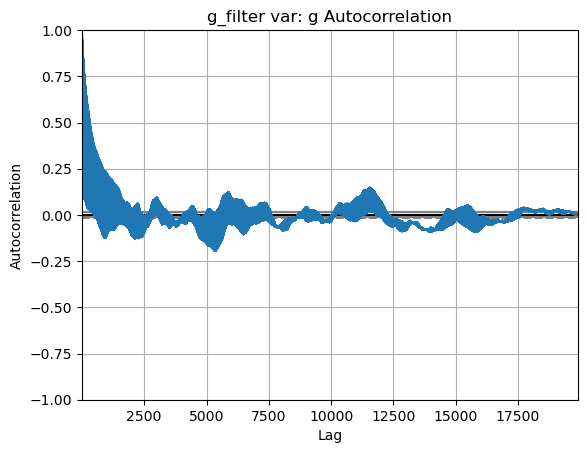

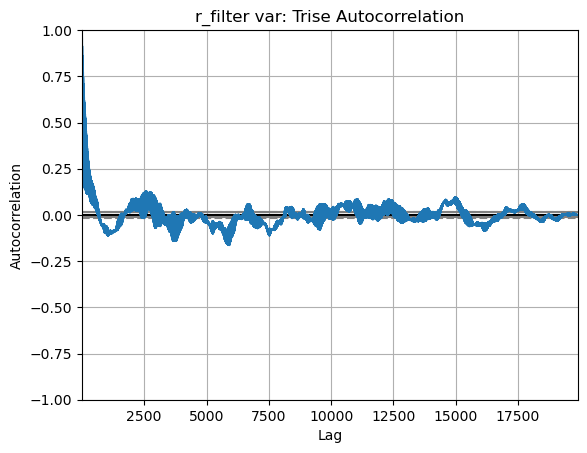

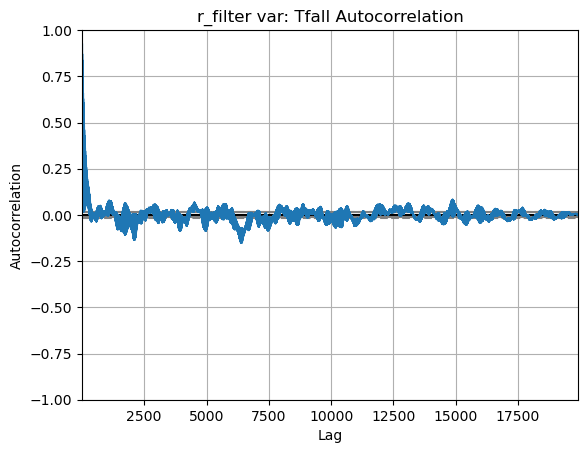

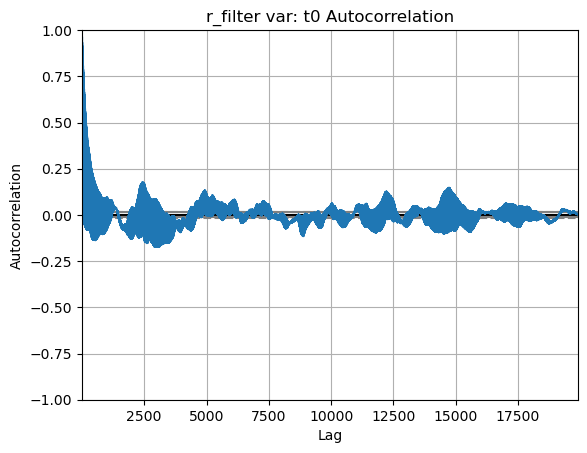

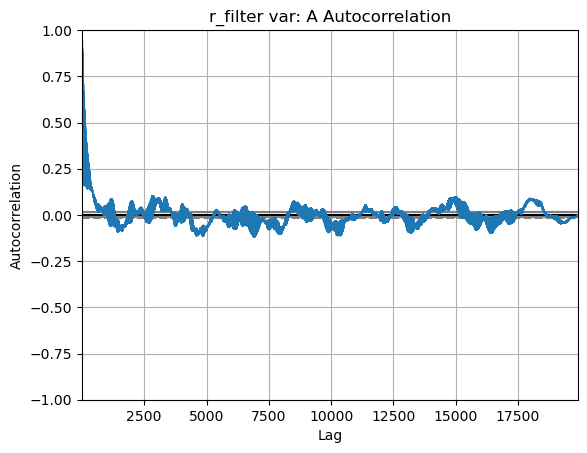

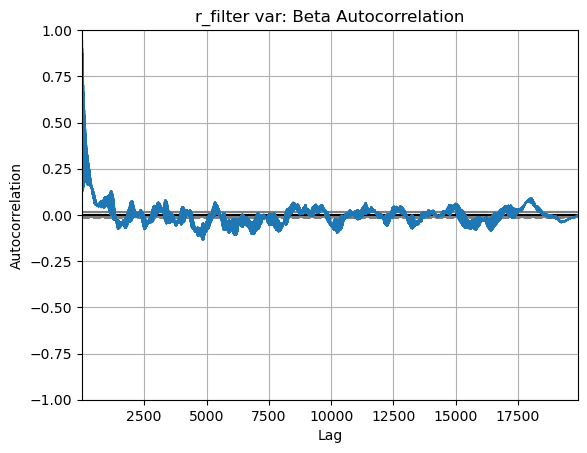

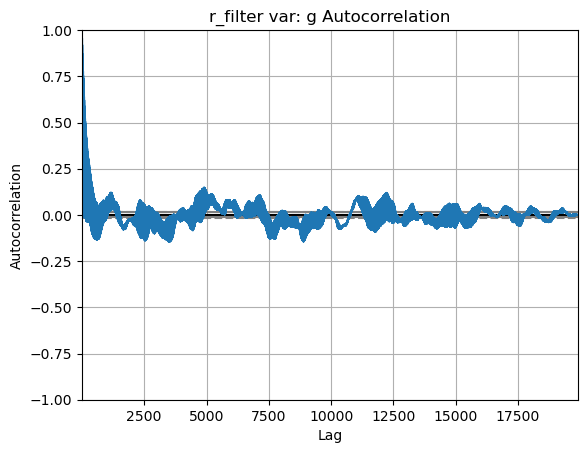

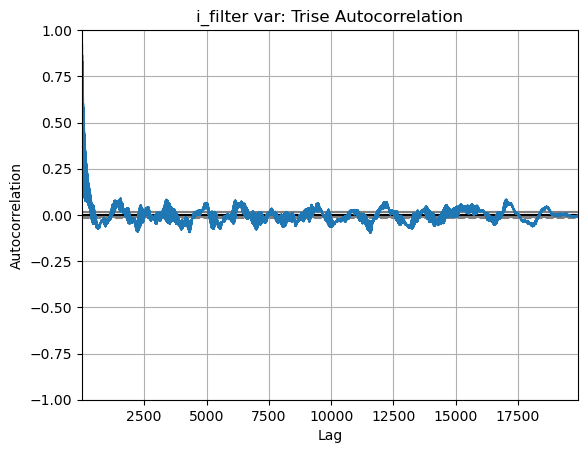

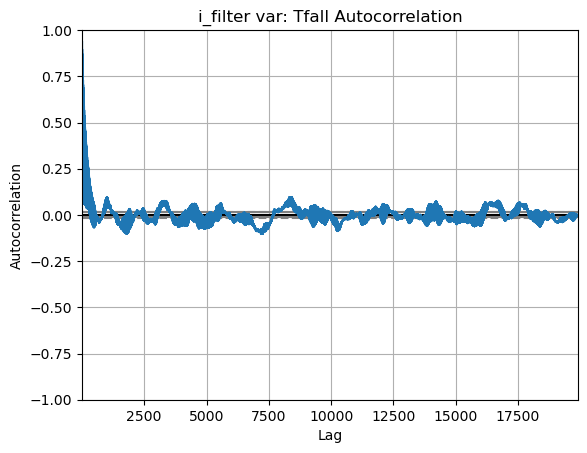

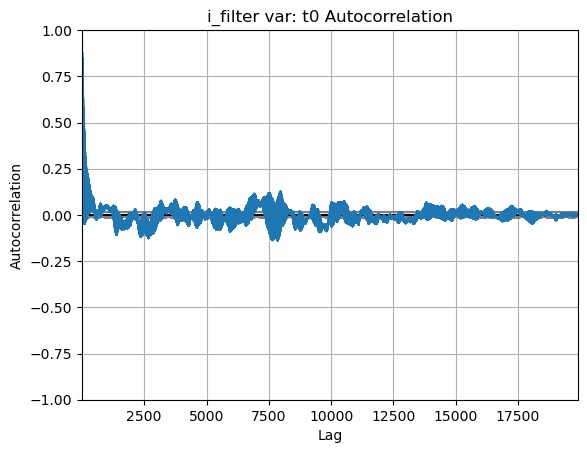

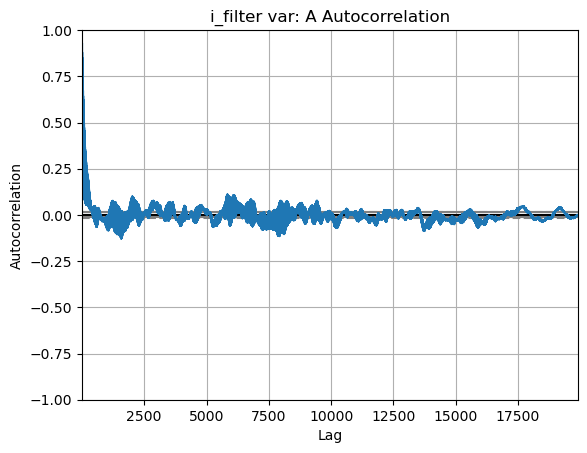

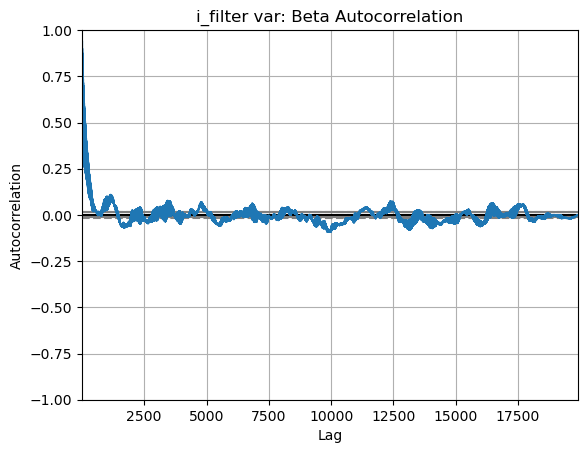

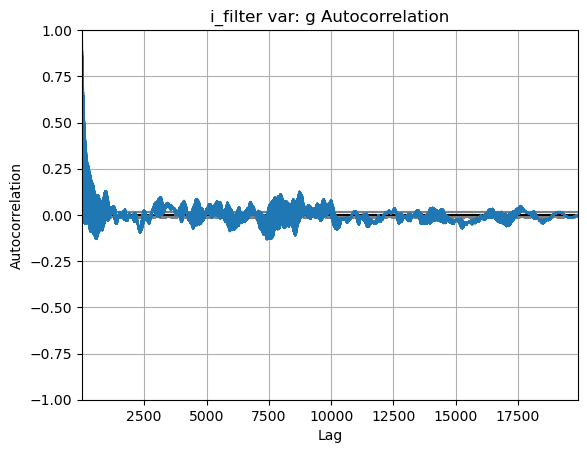

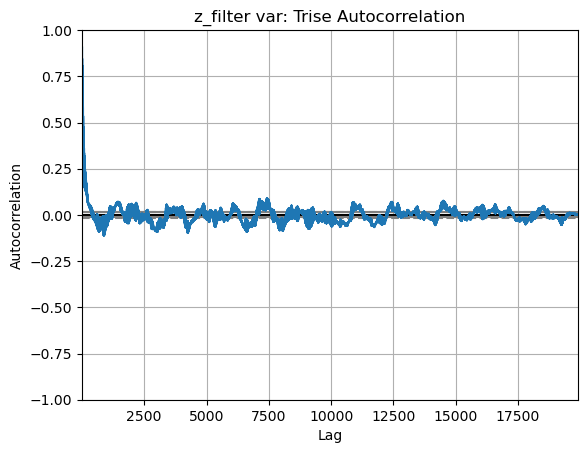

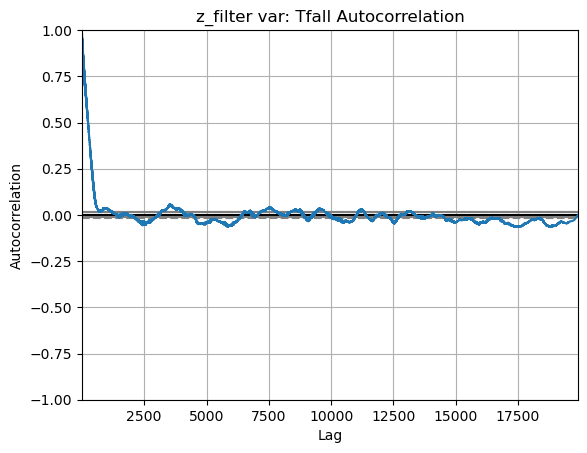

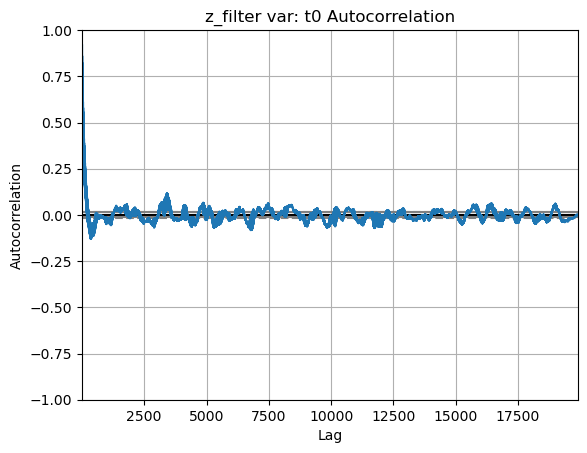

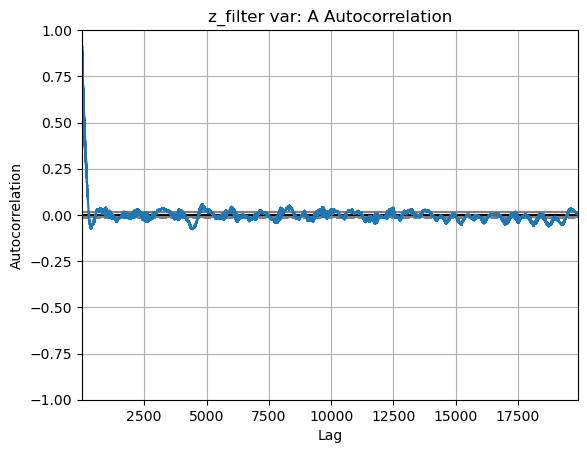

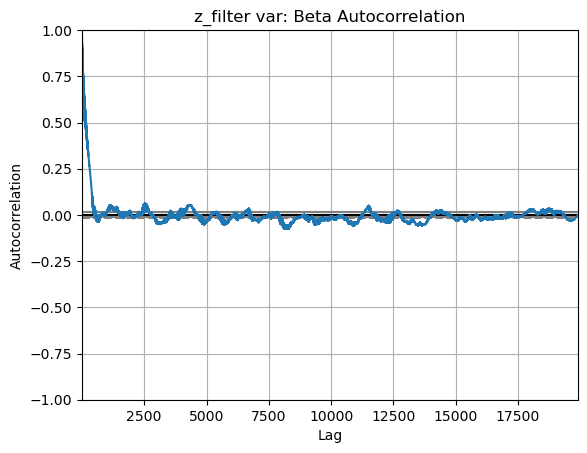

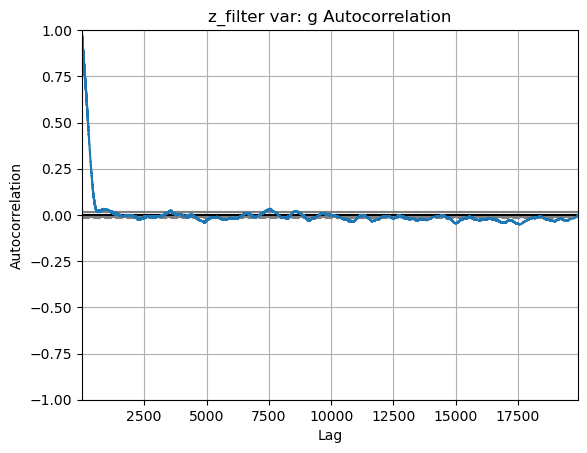

In [87]:
#auto correlation thinned
# 98
print('PS1_PS1MD_PSc000098 auto correlation plots, thinned by factor of 10')
label_list = ['g_filter', 'r_filter', 'i_filter', 'z_filter']
var_list = ['Trise', 'Tfall', 't0', 'A', 'Beta', 'g']
for i in range(4):
    samp_curr = samples_98[i]
    for j in range(6):
        pd.plotting.autocorrelation_plot(samp_curr[nburn::10,j])
        plt.title(label_list[i]+' var: '+var_list[j]+' Autocorrelation')
        plt.show()

PS1_PS1MD_PSc000174 auto correlation plots


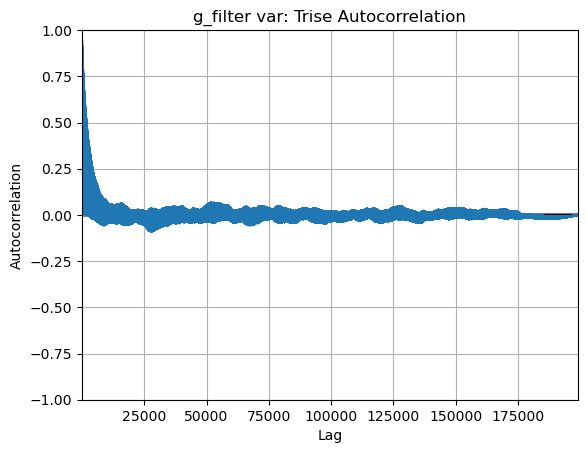

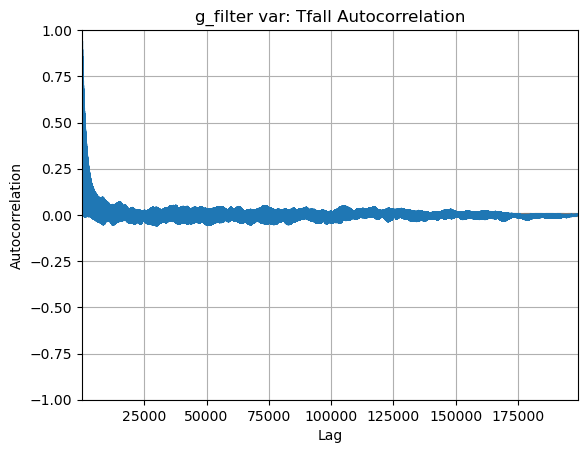

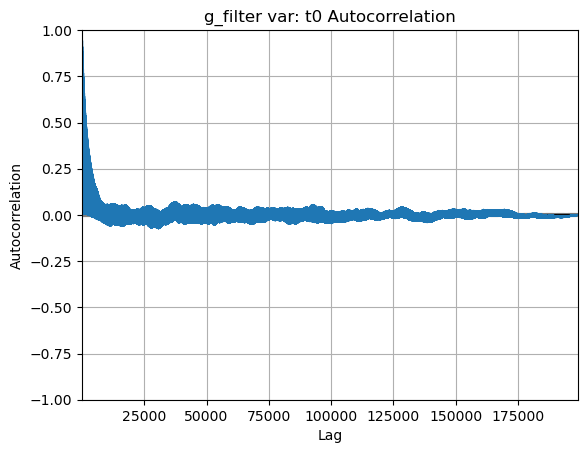

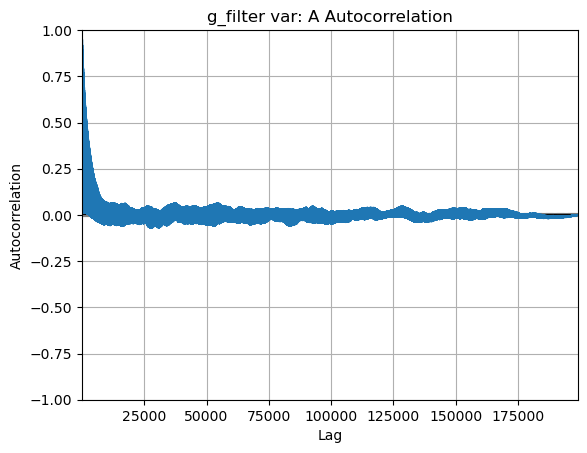

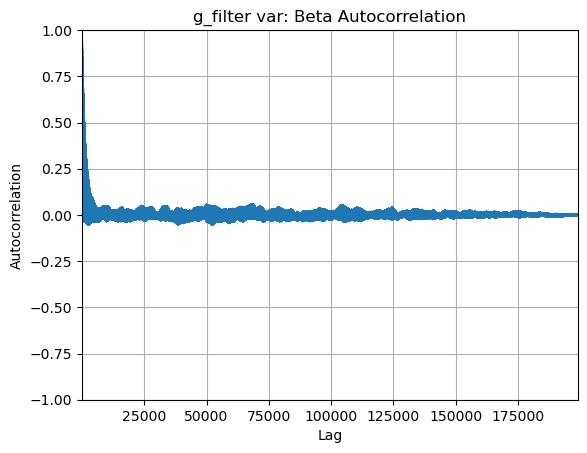

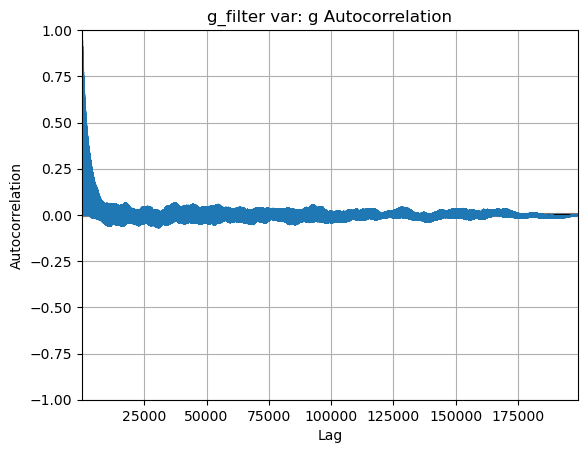

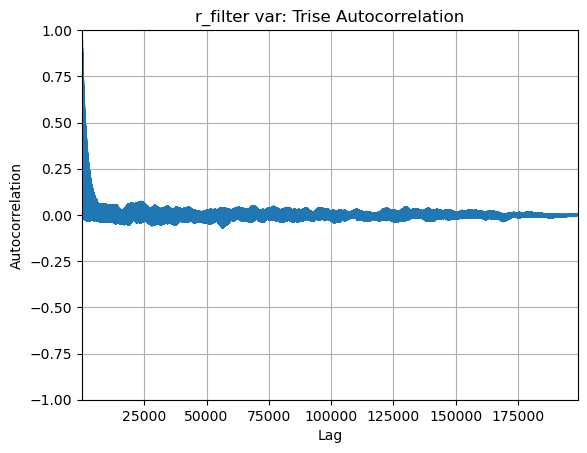

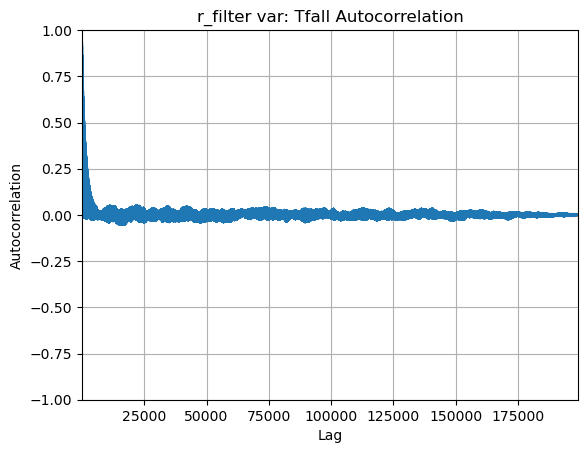

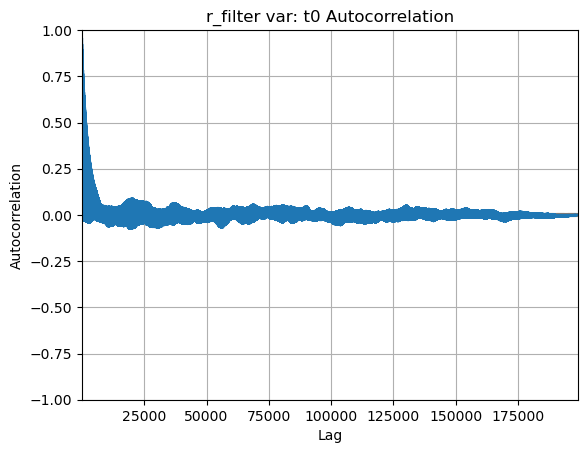

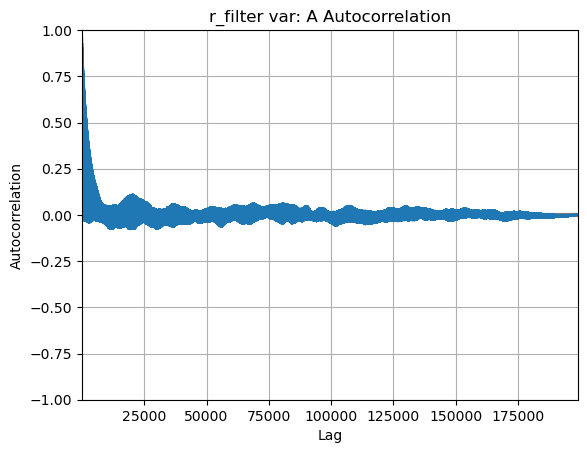

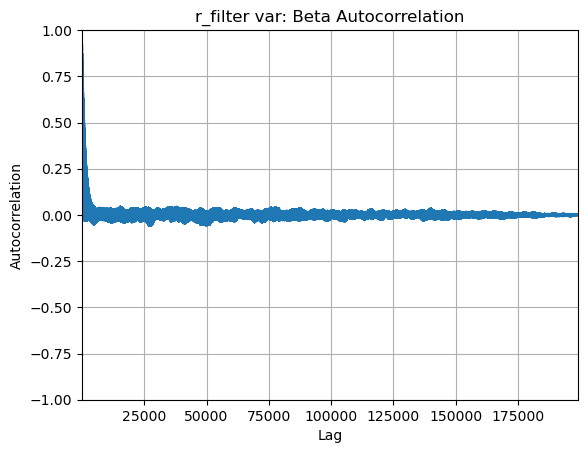

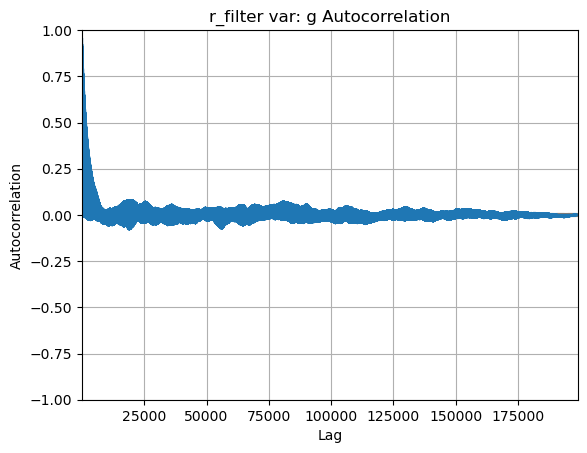

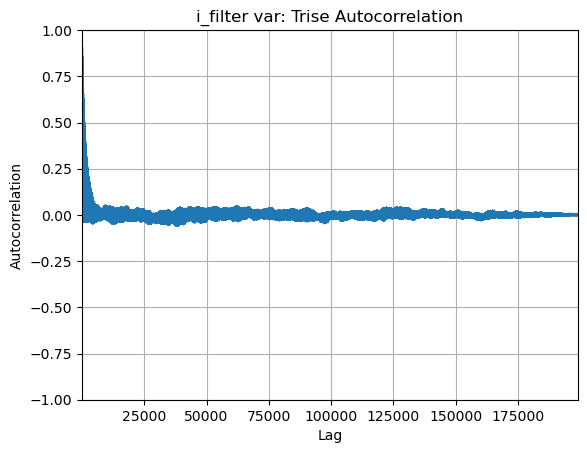

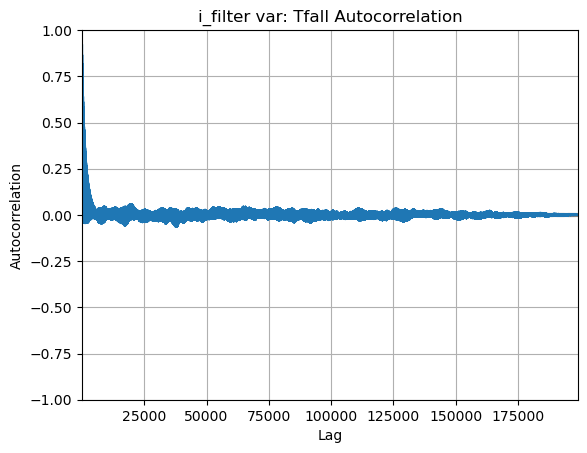

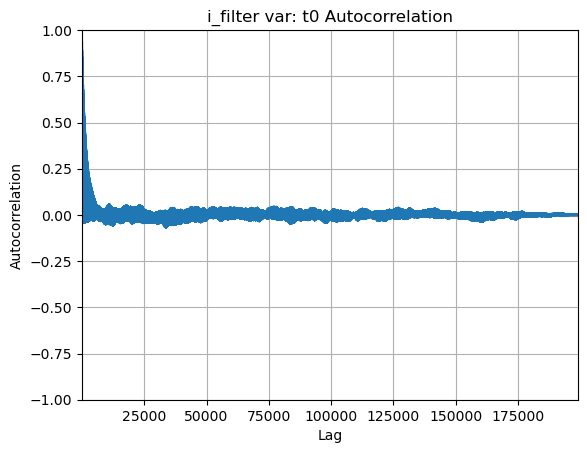

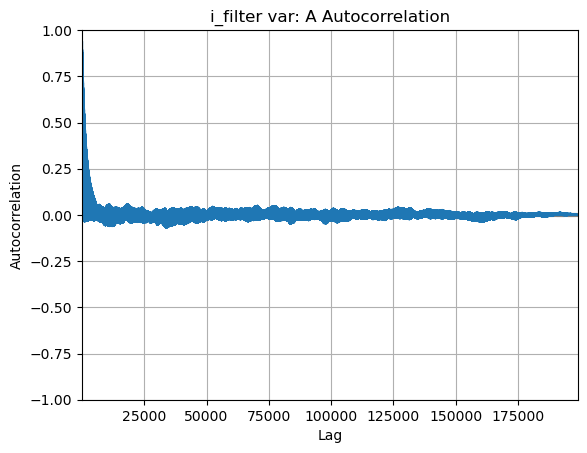

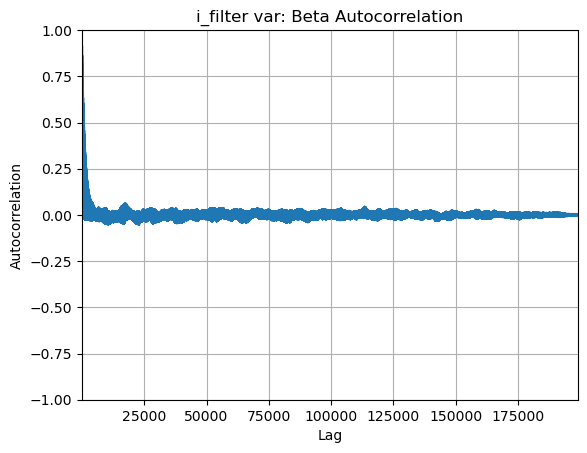

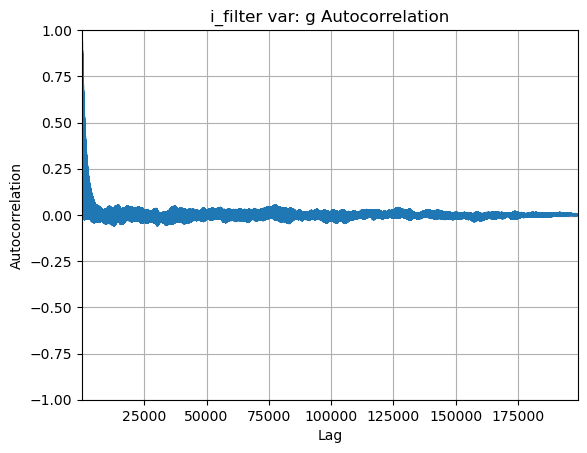

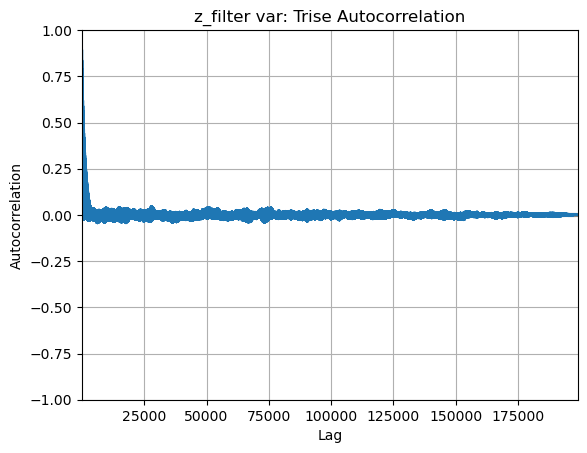

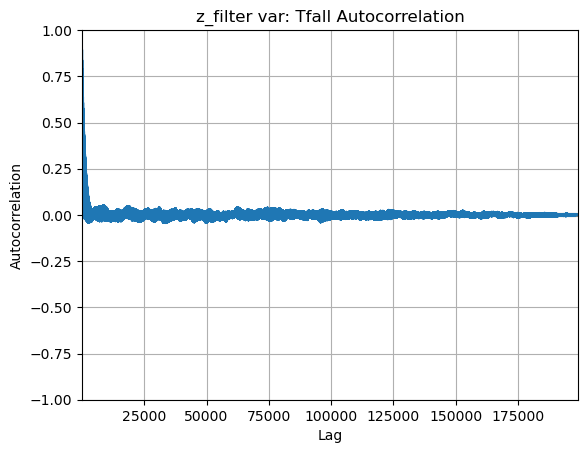

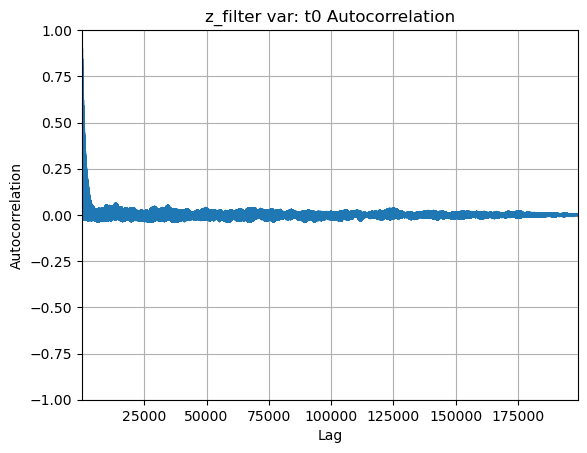

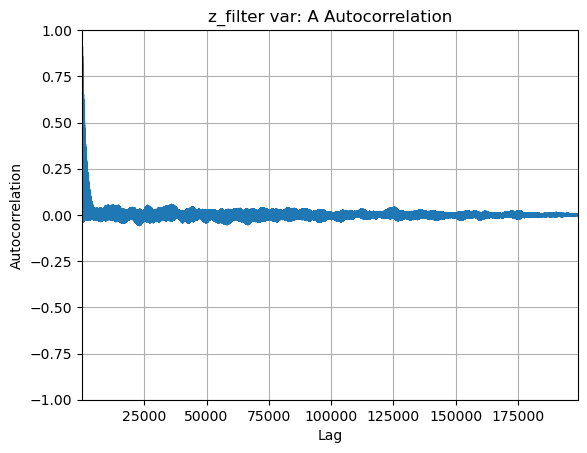

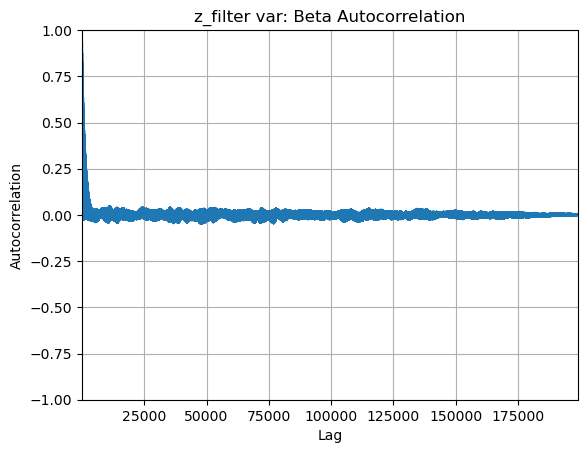

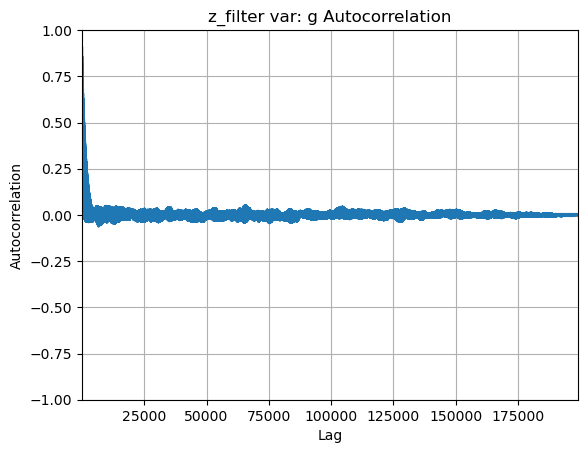

In [88]:
#auto correlation
# 174
print('PS1_PS1MD_PSc000174 auto correlation plots')
label_list = ['g_filter', 'r_filter', 'i_filter', 'z_filter']
var_list = ['Trise', 'Tfall', 't0', 'A', 'Beta', 'g']
for i in range(4):
    samp_curr = samples_174[i]
    for j in range(6):
        pd.plotting.autocorrelation_plot(samp_curr[nburn:,j])
        plt.title(label_list[i]+' var: '+var_list[j]+' Autocorrelation')
        plt.show()

PS1_PS1MD_PSc0000174 auto correlation plots, thinned by factor of 10


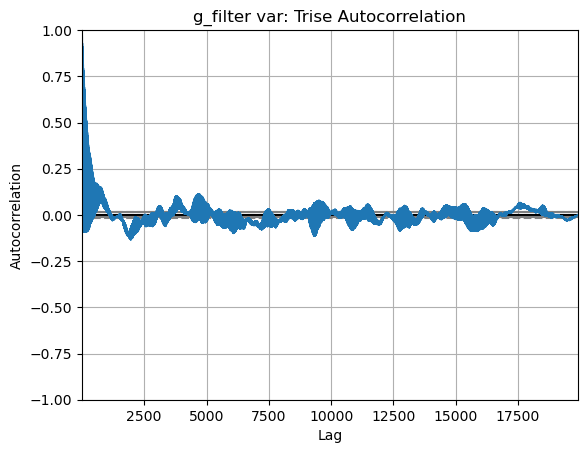

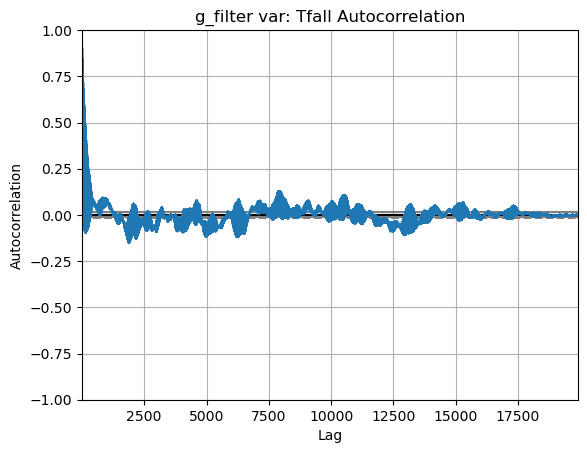

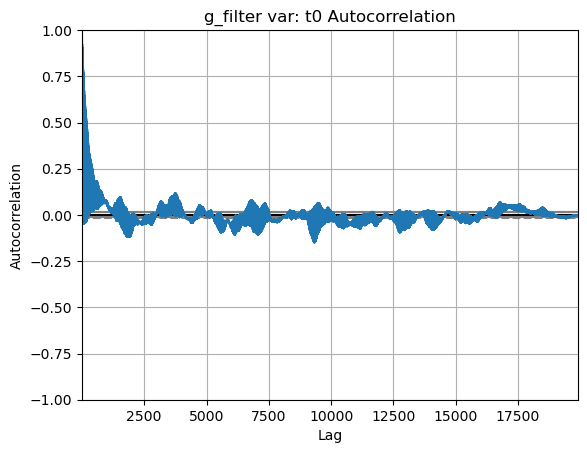

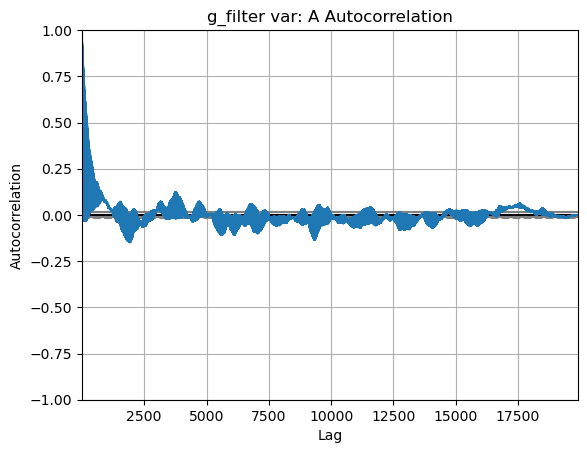

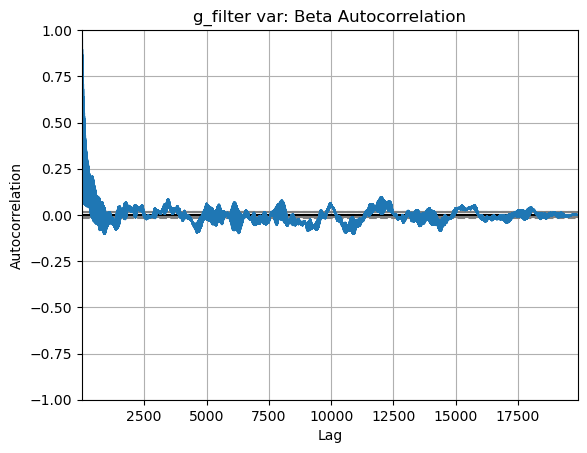

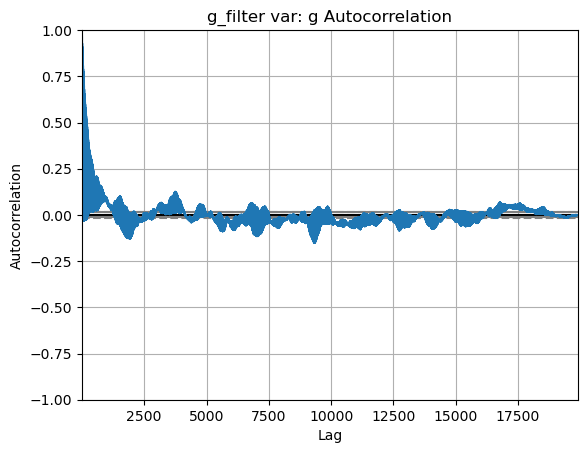

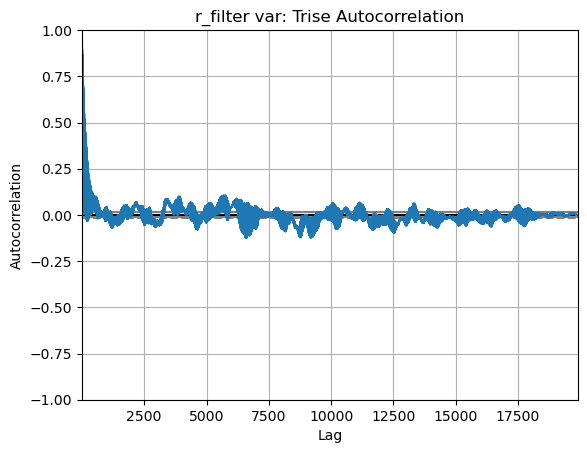

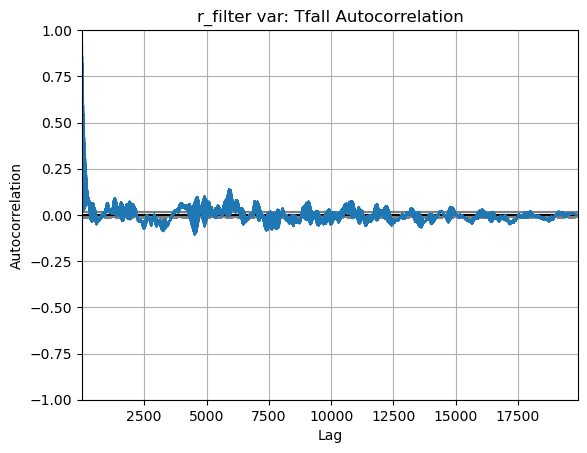

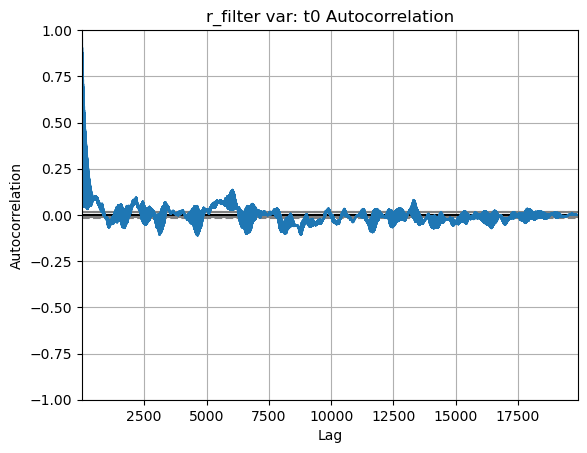

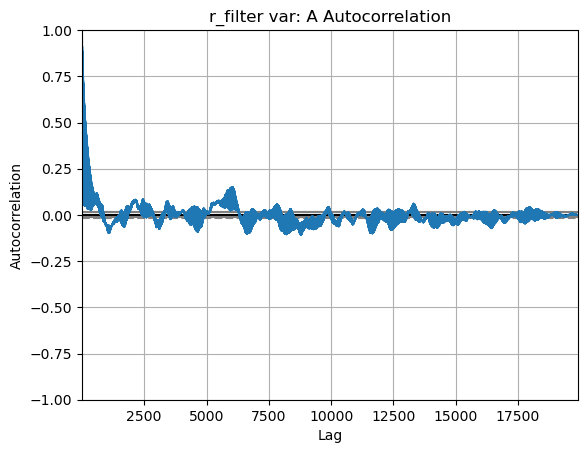

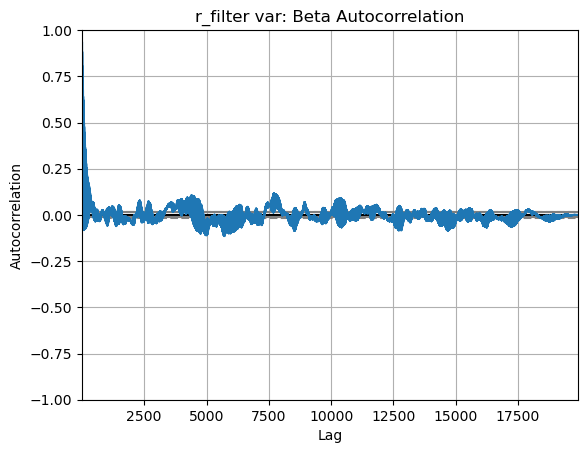

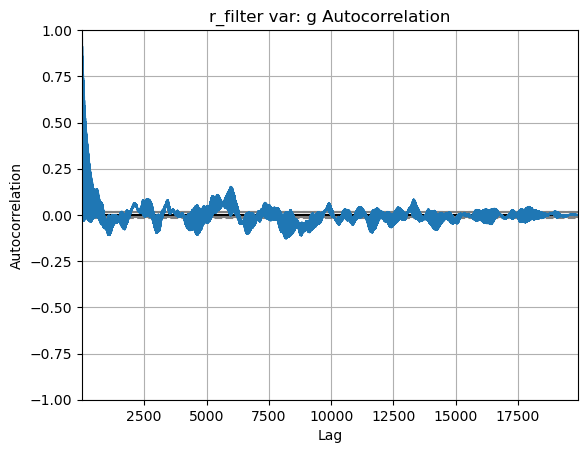

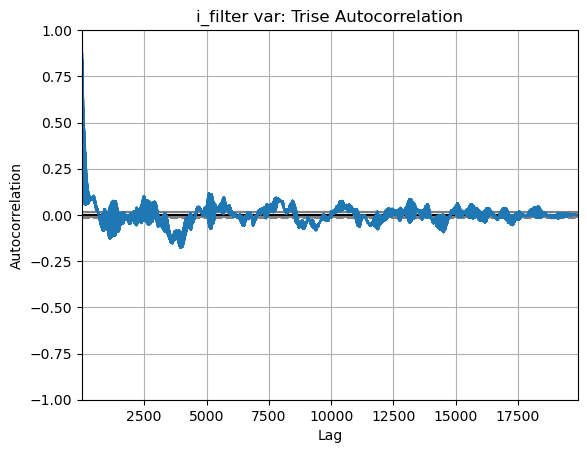

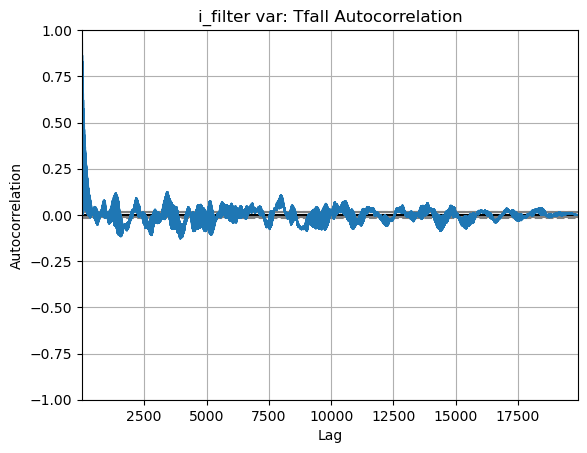

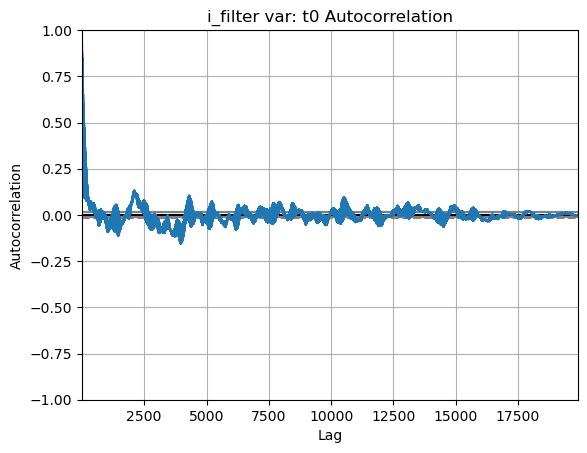

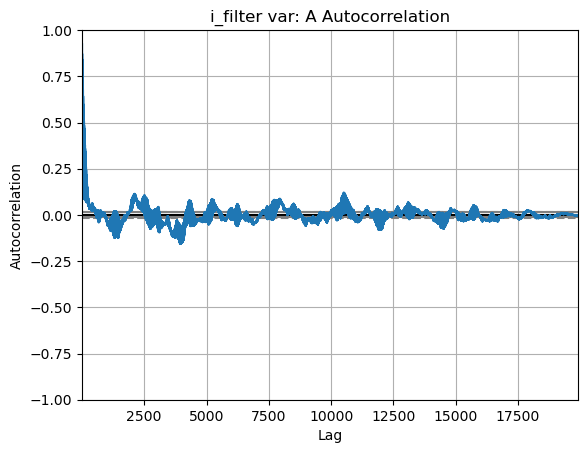

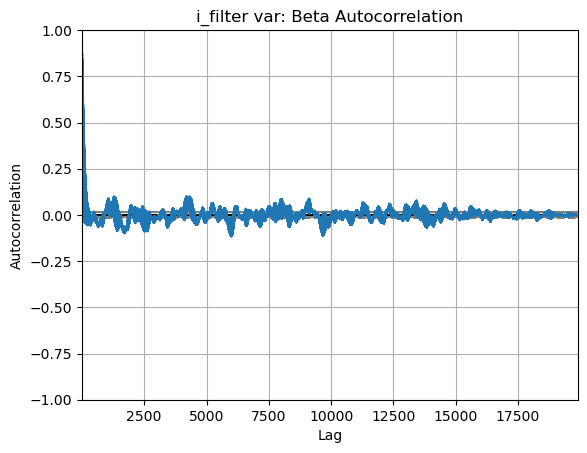

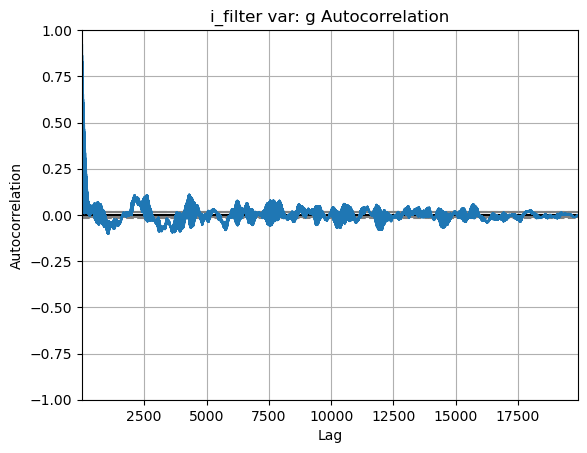

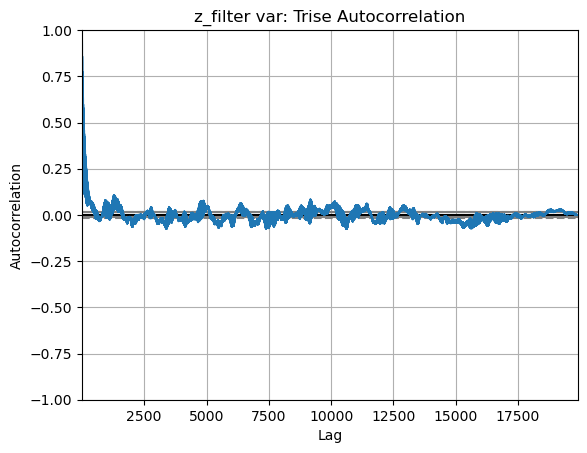

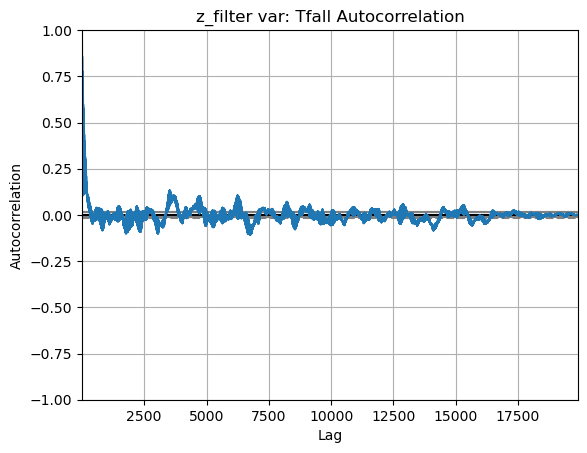

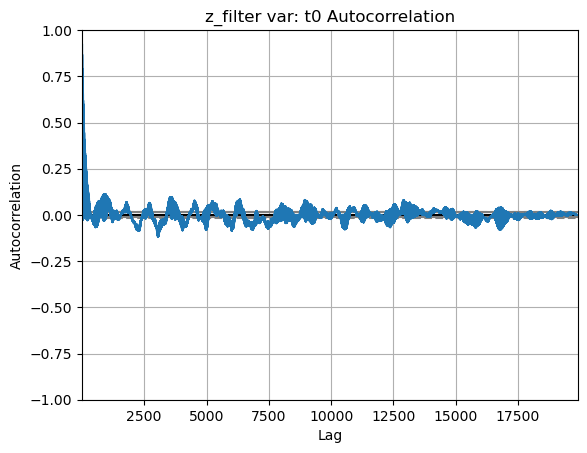

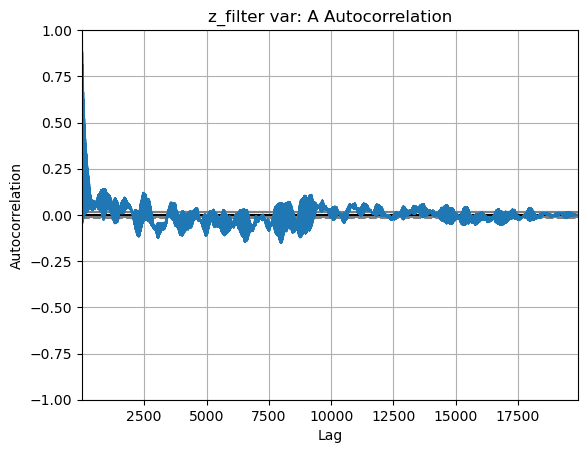

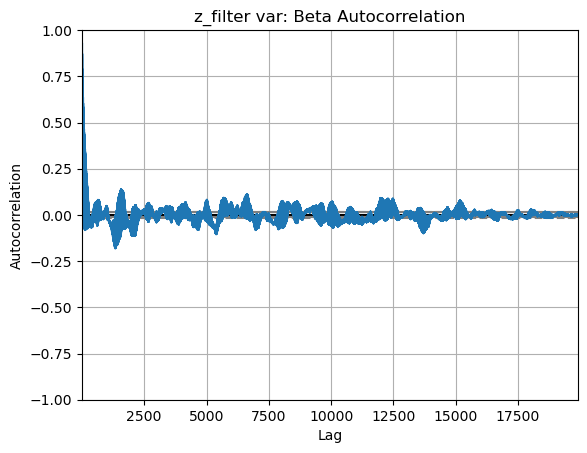

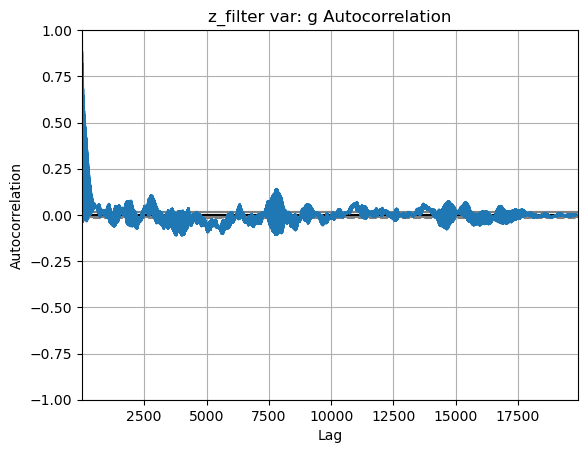

In [89]:
#auto correlation thinned
# 174
print('PS1_PS1MD_PSc0000174 auto correlation plots, thinned by factor of 10')
label_list = ['g_filter', 'r_filter', 'i_filter', 'z_filter']
var_list = ['Trise', 'Tfall', 't0', 'A', 'Beta', 'g']
for i in range(4):
    samp_curr = samples_174[i]
    for j in range(6):
        pd.plotting.autocorrelation_plot(samp_curr[nburn::10,j])
        plt.title(label_list[i]+' var: '+var_list[j]+' Autocorrelation')
        plt.show()

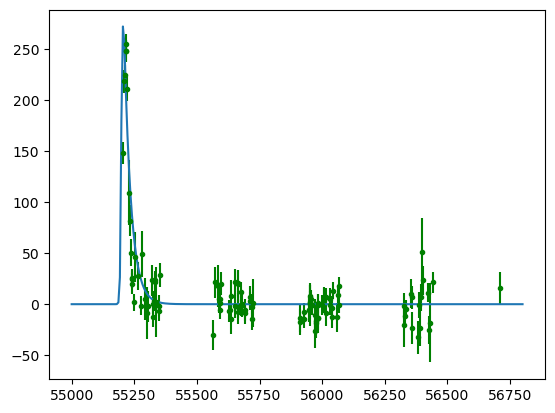

In [59]:
# Test code area
tr = 2.14
tf = 28.02
t0 = 55197.74
A = 300
Beta = -2.44
g = 11.12

var_list = [tr, tf, t0, A, Beta, g]

t_model = np.linspace(55000, 56800, 300)

F_model = model(var_list, t_model)

plt.errorbar(g_MJD_174, g_flux_174, g_fluxerr_174, fmt='g.', label='g filter')
plt.plot(t_model, F_model)
plt.show()